In [10]:
import pandas as pd
import numpy as np
from IPython.display import display

data_train = pd.read_csv("Deviation_co.csv", header=0)
data_test = pd.read_csv("Evaluation_co.csv", header=0)
data_validation = pd.read_csv("Validation_co.csv", header=0)
data_train.head(3)

,Unnamed: 0,DPM1,C1orf112,FGR,FUCA2,NIPAL3,LAS1L,ANKIB1,KRIT1,BAD,...,ENSG00000270055,ENSG00000271043,ENSG00000272053,ENSG00000272168,ENSG00000272369,ENSG00000272888,type,Stage,Gender,age
0,Vumc-GBM-454-TR1359,5.049122,3.487946,8.071979,4.638076,5.344565,4.280055,4.280055,5.107536,4.280055,...,3.487946,5.569030,6.768647,4.715240,4.513994,4.677174,Glioma,NaN,M,75.0
1,Vumc-GBM-506t0-TR1483,1.218640,3.394439,4.914904,1.218640,7.093956,3.785627,6.395904,3.150205,5.774303,...,3.394439,6.765185,7.537161,5.261353,5.261353,5.063605,Glioma,NaN,F,70.0
2,Radb-GBM-N14-01-TR2140,3.478985,3.478985,5.184209,5.686026,5.883755,1.218640,3.633490,1.218640,5.080546,...,4.408260,6.237081,8.005226,5.754991,3.305927,4.909589,Glioma,NaN,F,51.0


In [11]:
# 基因名称
feature_total = data_train.columns[1:].tolist()
feature_total = feature_total[:-4]
# 结局
outcome_variable = 'Stage'

In [12]:
# 获取结局类别
from collections import Counter
b = np.array(data_train[outcome_variable])
b = b.tolist()
b = dict(Counter(b)) # 列表计数
type_name = []
for key, value in b.items():
    type_name.append(key)
print(type_name)
type_name = ['I', 'II', 'III', 'IV']
type_name

[nan, 'IV', 'II', 'III', 'I']


['I', 'II', 'III', 'IV']

In [13]:
# 检查结局分类
print(data_train.Stage.value_counts())
print(data_test.Stage.value_counts())
print(data_validation.Stage.value_counts())

IV     329
III     92
II      75
I       48
Name: Stage, dtype: int64
IV     181
III     49
II      28
I       24
Name: Stage, dtype: int64
IV     350
III     94
II      63
I       39
Name: Stage, dtype: int64


In [14]:
import sklearn
from xgboost import XGBClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold

In [15]:
# 置信区间函数
import numpy as np
from scipy.stats import sem
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def Confidence_Interval(y_pred, y_true):
    print("Original ROC area: {:0.2f}".format(roc_auc_score(y_true, y_pred)))

    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
        print("Bootstrap #{} ROC area: {:0.2f}".format(i + 1, score))

    # 绘制柱状图
    plt.hist(bootstrapped_scores, bins=50)
    plt.title('Histogram of the bootstrapped ROC AUC scores')
    plt.show()

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    print("Confidence interval for the score: [{:0.2f} - {:0.2}]".format(
        confidence_lower, confidence_upper))
    confidence_lower, confidence_upper = format(confidence_lower, '.2f'), format(confidence_upper, '.2f')
    confidence_interval = '(' + str(confidence_lower) + '-' + str(format(confidence_upper)) + ')'

    return confidence_interval

# confidence_interval_test_RF = Confidence_Interval(model_RF.predict_proba(X_test)[:,1], y_test_np)

In [16]:
from sk_matrix import sk_matrix

<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


426
[15:09:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:

[15:09:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 1. TMSB4XP4                       0.201475
 2. CXCL8                          0.097086
 3. HBD                            0.056859
 4. KSR1                           0.055678
 5. LPCAT1                         0.049993
 6. C1orf87                        0.048771
 7. HDAC8                          0.040196
 8. EIF1AY                         0.038800
 9. ENSG00000187653         

D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:

[15:09:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:


Bootstrap #1 ROC area: 0.78
Bootstrap #2 ROC area: 0.81
Bootstrap #3 ROC area: 0.80
Bootstrap #4 ROC area: 0.77
Bootstrap #5 ROC area: 0.75
Bootstrap #6 ROC area: 0.75
Bootstrap #7 ROC area: 0.78
Bootstrap #8 ROC area: 0.77
Bootstrap #9 ROC area: 0.79
Bootstrap #10 ROC area: 0.79
Bootstrap #11 ROC area: 0.73
Bootstrap #12 ROC area: 0.66
Bootstrap #13 ROC area: 0.72
Bootstrap #14 ROC area: 0.79
Bootstrap #15 ROC area: 0.70
Bootstrap #16 ROC area: 0.80
Bootstrap #17 ROC area: 0.82
Bootstrap #18 ROC area: 0.79
Bootstrap #19 ROC area: 0.69
Bootstrap #20 ROC area: 0.78
Bootstrap #21 ROC area: 0.81
Bootstrap #22 ROC area: 0.73
Bootstrap #23 ROC area: 0.68
Bootstrap #24 ROC area: 0.76
Bootstrap #25 ROC area: 0.74
Bootstrap #26 ROC area: 0.73
Bootstrap #27 ROC area: 0.84
Bootstrap #28 ROC area: 0.75
Bootstrap #29 ROC area: 0.77
Bootstrap #30 ROC area: 0.79
Bootstrap #31 ROC area: 0.75
Bootstrap #32 ROC area: 0.78
Bootstrap #33 ROC area: 0.77
Bootstrap #34 ROC area: 0.80
Bootstrap #35 ROC area

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 

Bootstrap #147 ROC area: 0.73
Bootstrap #148 ROC area: 0.68
Bootstrap #149 ROC area: 0.72
Bootstrap #150 ROC area: 0.75
Bootstrap #151 ROC area: 0.73
Bootstrap #152 ROC area: 0.79
Bootstrap #153 ROC area: 0.85
Bootstrap #154 ROC area: 0.75
Bootstrap #155 ROC area: 0.78
Bootstrap #156 ROC area: 0.73
Bootstrap #157 ROC area: 0.71
Bootstrap #158 ROC area: 0.84
Bootstrap #159 ROC area: 0.78
Bootstrap #160 ROC area: 0.70
Bootstrap #161 ROC area: 0.75
Bootstrap #162 ROC area: 0.77
Bootstrap #163 ROC area: 0.77
Bootstrap #164 ROC area: 0.83
Bootstrap #165 ROC area: 0.86
Bootstrap #166 ROC area: 0.66
Bootstrap #167 ROC area: 0.85
Bootstrap #168 ROC area: 0.84
Bootstrap #169 ROC area: 0.77
Bootstrap #170 ROC area: 0.75
Bootstrap #171 ROC area: 0.72
Bootstrap #172 ROC area: 0.80
Bootstrap #173 ROC area: 0.72
Bootstrap #174 ROC area: 0.80
Bootstrap #175 ROC area: 0.69
Bootstrap #176 ROC area: 0.73
Bootstrap #177 ROC area: 0.75
Bootstrap #178 ROC area: 0.74
Bootstrap #179 ROC area: 0.82
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 

Bootstrap #304 ROC area: 0.76
Bootstrap #305 ROC area: 0.83
Bootstrap #306 ROC area: 0.74
Bootstrap #307 ROC area: 0.78
Bootstrap #308 ROC area: 0.78
Bootstrap #309 ROC area: 0.79
Bootstrap #310 ROC area: 0.76
Bootstrap #311 ROC area: 0.67
Bootstrap #312 ROC area: 0.70
Bootstrap #313 ROC area: 0.75
Bootstrap #314 ROC area: 0.81
Bootstrap #315 ROC area: 0.76
Bootstrap #316 ROC area: 0.87
Bootstrap #317 ROC area: 0.79
Bootstrap #318 ROC area: 0.78
Bootstrap #319 ROC area: 0.83
Bootstrap #320 ROC area: 0.82
Bootstrap #321 ROC area: 0.65
Bootstrap #322 ROC area: 0.86
Bootstrap #323 ROC area: 0.78
Bootstrap #324 ROC area: 0.77
Bootstrap #325 ROC area: 0.73
Bootstrap #326 ROC area: 0.77
Bootstrap #327 ROC area: 0.79
Bootstrap #328 ROC area: 0.76
Bootstrap #329 ROC area: 0.75
Bootstrap #330 ROC area: 0.78
Bootstrap #331 ROC area: 0.84
Bootstrap #332 ROC area: 0.80
Bootstrap #333 ROC area: 0.75
Bootstrap #334 ROC area: 0.75
Bootstrap #335 ROC area: 0.67
Bootstrap #336 ROC area: 0.83
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 

Bootstrap #469 ROC area: 0.72
Bootstrap #470 ROC area: 0.72
Bootstrap #471 ROC area: 0.75
Bootstrap #472 ROC area: 0.75
Bootstrap #473 ROC area: 0.76
Bootstrap #474 ROC area: 0.65
Bootstrap #475 ROC area: 0.76
Bootstrap #476 ROC area: 0.76
Bootstrap #477 ROC area: 0.76
Bootstrap #478 ROC area: 0.77
Bootstrap #479 ROC area: 0.79
Bootstrap #480 ROC area: 0.72
Bootstrap #481 ROC area: 0.78
Bootstrap #482 ROC area: 0.83
Bootstrap #483 ROC area: 0.74
Bootstrap #484 ROC area: 0.75
Bootstrap #485 ROC area: 0.69
Bootstrap #486 ROC area: 0.66
Bootstrap #487 ROC area: 0.80
Bootstrap #488 ROC area: 0.77
Bootstrap #489 ROC area: 0.71
Bootstrap #490 ROC area: 0.71
Bootstrap #491 ROC area: 0.62
Bootstrap #492 ROC area: 0.76
Bootstrap #493 ROC area: 0.80
Bootstrap #494 ROC area: 0.72
Bootstrap #495 ROC area: 0.81
Bootstrap #496 ROC area: 0.81
Bootstrap #497 ROC area: 0.78
Bootstrap #498 ROC area: 0.78
Bootstrap #499 ROC area: 0.81
Bootstrap #500 ROC area: 0.66
Bootstrap #501 ROC area: 0.68
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 

Bootstrap #622 ROC area: 0.82
Bootstrap #623 ROC area: 0.77
Bootstrap #624 ROC area: 0.75
Bootstrap #625 ROC area: 0.73
Bootstrap #626 ROC area: 0.70
Bootstrap #627 ROC area: 0.79
Bootstrap #628 ROC area: 0.76
Bootstrap #629 ROC area: 0.69
Bootstrap #630 ROC area: 0.76
Bootstrap #631 ROC area: 0.81
Bootstrap #632 ROC area: 0.76
Bootstrap #633 ROC area: 0.72
Bootstrap #634 ROC area: 0.86
Bootstrap #635 ROC area: 0.78
Bootstrap #636 ROC area: 0.78
Bootstrap #637 ROC area: 0.81
Bootstrap #638 ROC area: 0.81
Bootstrap #639 ROC area: 0.73
Bootstrap #640 ROC area: 0.70
Bootstrap #641 ROC area: 0.77
Bootstrap #642 ROC area: 0.78
Bootstrap #643 ROC area: 0.84
Bootstrap #644 ROC area: 0.74
Bootstrap #645 ROC area: 0.72
Bootstrap #646 ROC area: 0.78
Bootstrap #647 ROC area: 0.68
Bootstrap #648 ROC area: 0.77
Bootstrap #649 ROC area: 0.83
Bootstrap #650 ROC area: 0.72
Bootstrap #651 ROC area: 0.74
Bootstrap #652 ROC area: 0.70
Bootstrap #653 ROC area: 0.78
Bootstrap #654 ROC area: 0.74
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 


Bootstrap #772 ROC area: 0.71
Bootstrap #773 ROC area: 0.74
Bootstrap #774 ROC area: 0.79
Bootstrap #775 ROC area: 0.77
Bootstrap #776 ROC area: 0.69
Bootstrap #777 ROC area: 0.77
Bootstrap #778 ROC area: 0.77
Bootstrap #779 ROC area: 0.85
Bootstrap #780 ROC area: 0.73
Bootstrap #781 ROC area: 0.82
Bootstrap #782 ROC area: 0.80
Bootstrap #783 ROC area: 0.74
Bootstrap #784 ROC area: 0.71
Bootstrap #785 ROC area: 0.80
Bootstrap #786 ROC area: 0.77
Bootstrap #787 ROC area: 0.74
Bootstrap #788 ROC area: 0.77
Bootstrap #789 ROC area: 0.73
Bootstrap #790 ROC area: 0.83
Bootstrap #791 ROC area: 0.76
Bootstrap #792 ROC area: 0.71
Bootstrap #793 ROC area: 0.76
Bootstrap #794 ROC area: 0.77
Bootstrap #795 ROC area: 0.76
Bootstrap #796 ROC area: 0.74
Bootstrap #797 ROC area: 0.78
Bootstrap #798 ROC area: 0.73
Bootstrap #799 ROC area: 0.75
Bootstrap #800 ROC area: 0.80
Bootstrap #801 ROC area: 0.83
Bootstrap #802 ROC area: 0.80
Bootstrap #803 ROC area: 0.78
Bootstrap #804 ROC area: 0.74
Bootstrap

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 

Bootstrap #921 ROC area: 0.77
Bootstrap #922 ROC area: 0.64
Bootstrap #923 ROC area: 0.73
Bootstrap #924 ROC area: 0.70
Bootstrap #925 ROC area: 0.72
Bootstrap #926 ROC area: 0.65
Bootstrap #927 ROC area: 0.67
Bootstrap #928 ROC area: 0.81
Bootstrap #929 ROC area: 0.73
Bootstrap #930 ROC area: 0.68
Bootstrap #931 ROC area: 0.69
Bootstrap #932 ROC area: 0.73
Bootstrap #933 ROC area: 0.73
Bootstrap #934 ROC area: 0.62
Bootstrap #935 ROC area: 0.76
Bootstrap #936 ROC area: 0.73
Bootstrap #937 ROC area: 0.74
Bootstrap #938 ROC area: 0.73
Bootstrap #939 ROC area: 0.78
Bootstrap #940 ROC area: 0.85
Bootstrap #941 ROC area: 0.71
Bootstrap #942 ROC area: 0.82
Bootstrap #943 ROC area: 0.65
Bootstrap #944 ROC area: 0.77
Bootstrap #945 ROC area: 0.78
Bootstrap #946 ROC area: 0.76
Bootstrap #947 ROC area: 0.74
Bootstrap #948 ROC area: 0.77
Bootstrap #949 ROC area: 0.70
Bootstrap #950 ROC area: 0.79
Bootstrap #951 ROC area: 0.75
Bootstrap #952 ROC area: 0.73
Bootstrap #953 ROC area: 0.74
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 

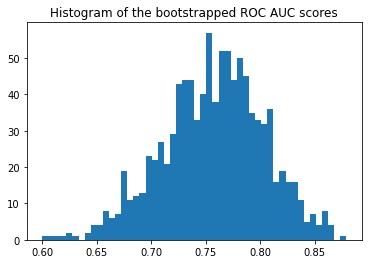

Confidence interval for the score: [0.68 - 0.83]
Original ROC area: 0.99
Bootstrap #1 ROC area: 0.99
Bootstrap #2 ROC area: 0.99
Bootstrap #3 ROC area: 0.99
Bootstrap #4 ROC area: 0.99
Bootstrap #5 ROC area: 0.99
Bootstrap #6 ROC area: 0.99
Bootstrap #7 ROC area: 0.99
Bootstrap #8 ROC area: 0.99
Bootstrap #9 ROC area: 0.99
Bootstrap #10 ROC area: 0.99
Bootstrap #11 ROC area: 0.99
Bootstrap #12 ROC area: 0.99
Bootstrap #13 ROC area: 0.99
Bootstrap #14 ROC area: 0.99
Bootstrap #15 ROC area: 0.99
Bootstrap #16 ROC area: 0.99
Bootstrap #17 ROC area: 0.99
Bootstrap #18 ROC area: 0.99
Bootstrap #19 ROC area: 0.99
Bootstrap #20 ROC area: 0.99
Bootstrap #21 ROC area: 0.99
Bootstrap #22 ROC area: 0.99
Bootstrap #23 ROC area: 0.98
Bootstrap #24 ROC area: 0.99
Bootstrap #25 ROC area: 0.99
Bootstrap #26 ROC area: 0.99
Bootstrap #27 ROC area: 0.98
Bootstrap #28 ROC area: 0.99
Bootstrap #29 ROC area: 0.99
Bootstrap #30 ROC area: 0.99
Bootstrap #31 ROC area: 0.99
Bootstrap #32 ROC area: 0.99
Bootstra

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarn


Bootstrap #101 ROC area: 0.99
Bootstrap #102 ROC area: 0.99
Bootstrap #103 ROC area: 0.99
Bootstrap #104 ROC area: 0.99
Bootstrap #105 ROC area: 0.99
Bootstrap #106 ROC area: 0.99
Bootstrap #107 ROC area: 0.99
Bootstrap #108 ROC area: 0.99
Bootstrap #109 ROC area: 0.99
Bootstrap #110 ROC area: 0.99
Bootstrap #111 ROC area: 0.99
Bootstrap #112 ROC area: 0.99
Bootstrap #113 ROC area: 0.99
Bootstrap #114 ROC area: 0.99
Bootstrap #115 ROC area: 0.99
Bootstrap #116 ROC area: 0.99
Bootstrap #117 ROC area: 0.99
Bootstrap #118 ROC area: 0.99
Bootstrap #119 ROC area: 0.99
Bootstrap #120 ROC area: 0.99
Bootstrap #121 ROC area: 0.99
Bootstrap #122 ROC area: 0.99
Bootstrap #123 ROC area: 0.99
Bootstrap #124 ROC area: 0.99
Bootstrap #125 ROC area: 0.99
Bootstrap #126 ROC area: 0.99
Bootstrap #127 ROC area: 0.99
Bootstrap #128 ROC area: 0.99
Bootstrap #129 ROC area: 0.99
Bootstrap #130 ROC area: 0.99
Bootstrap #131 ROC area: 0.99
Bootstrap #132 ROC area: 0.99
Bootstrap #133 ROC area: 0.99
Bootstrap

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarn


Bootstrap #215 ROC area: 0.99
Bootstrap #216 ROC area: 0.99
Bootstrap #217 ROC area: 0.99
Bootstrap #218 ROC area: 0.99
Bootstrap #219 ROC area: 0.99
Bootstrap #220 ROC area: 0.99
Bootstrap #221 ROC area: 0.99
Bootstrap #222 ROC area: 0.99
Bootstrap #223 ROC area: 0.99
Bootstrap #224 ROC area: 0.99
Bootstrap #225 ROC area: 0.99
Bootstrap #226 ROC area: 0.99
Bootstrap #227 ROC area: 0.99
Bootstrap #228 ROC area: 0.99
Bootstrap #229 ROC area: 0.99
Bootstrap #230 ROC area: 0.99
Bootstrap #231 ROC area: 0.99
Bootstrap #232 ROC area: 0.99
Bootstrap #233 ROC area: 0.99
Bootstrap #234 ROC area: 0.99
Bootstrap #235 ROC area: 0.99
Bootstrap #236 ROC area: 0.99
Bootstrap #237 ROC area: 0.99
Bootstrap #238 ROC area: 0.99
Bootstrap #239 ROC area: 0.99
Bootstrap #240 ROC area: 0.99
Bootstrap #241 ROC area: 0.99
Bootstrap #242 ROC area: 0.99
Bootstrap #243 ROC area: 0.99
Bootstrap #244 ROC area: 0.99
Bootstrap #245 ROC area: 0.99
Bootstrap #246 ROC area: 0.99
Bootstrap #247 ROC area: 0.99
Bootstrap

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarn

Bootstrap #343 ROC area: 0.99
Bootstrap #344 ROC area: 0.99
Bootstrap #345 ROC area: 0.99
Bootstrap #346 ROC area: 0.99
Bootstrap #347 ROC area: 0.99
Bootstrap #348 ROC area: 0.98
Bootstrap #349 ROC area: 0.99
Bootstrap #350 ROC area: 0.99
Bootstrap #351 ROC area: 0.98
Bootstrap #352 ROC area: 0.99
Bootstrap #353 ROC area: 0.99
Bootstrap #354 ROC area: 0.98
Bootstrap #355 ROC area: 0.99
Bootstrap #356 ROC area: 0.99
Bootstrap #357 ROC area: 0.99
Bootstrap #358 ROC area: 0.99
Bootstrap #359 ROC area: 0.99
Bootstrap #360 ROC area: 0.99
Bootstrap #361 ROC area: 0.99
Bootstrap #362 ROC area: 0.99
Bootstrap #363 ROC area: 0.99
Bootstrap #364 ROC area: 0.99
Bootstrap #365 ROC area: 0.99
Bootstrap #366 ROC area: 0.99
Bootstrap #367 ROC area: 0.99
Bootstrap #368 ROC area: 0.99
Bootstrap #369 ROC area: 0.99
Bootstrap #370 ROC area: 0.99
Bootstrap #371 ROC area: 0.99
Bootstrap #372 ROC area: 0.99
Bootstrap #373 ROC area: 0.99
Bootstrap #374 ROC area: 0.99
Bootstrap #375 ROC area: 0.99
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarn

Bootstrap #468 ROC area: 0.99
Bootstrap #469 ROC area: 0.99
Bootstrap #470 ROC area: 0.99
Bootstrap #471 ROC area: 0.99
Bootstrap #472 ROC area: 0.99
Bootstrap #473 ROC area: 0.99
Bootstrap #474 ROC area: 0.99
Bootstrap #475 ROC area: 0.99
Bootstrap #476 ROC area: 0.99
Bootstrap #477 ROC area: 0.99
Bootstrap #478 ROC area: 0.99
Bootstrap #479 ROC area: 0.99
Bootstrap #480 ROC area: 0.99
Bootstrap #481 ROC area: 0.99
Bootstrap #482 ROC area: 0.99
Bootstrap #483 ROC area: 0.98
Bootstrap #484 ROC area: 0.99
Bootstrap #485 ROC area: 0.99
Bootstrap #486 ROC area: 0.99
Bootstrap #487 ROC area: 0.99
Bootstrap #488 ROC area: 0.99
Bootstrap #489 ROC area: 0.99
Bootstrap #490 ROC area: 0.99
Bootstrap #491 ROC area: 0.99
Bootstrap #492 ROC area: 0.99
Bootstrap #493 ROC area: 0.99
Bootstrap #494 ROC area: 0.99
Bootstrap #495 ROC area: 0.98
Bootstrap #496 ROC area: 0.99
Bootstrap #497 ROC area: 0.99
Bootstrap #498 ROC area: 0.99
Bootstrap #499 ROC area: 0.99
Bootstrap #500 ROC area: 0.99
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarn

Bootstrap #594 ROC area: 0.99
Bootstrap #595 ROC area: 0.99
Bootstrap #596 ROC area: 0.99
Bootstrap #597 ROC area: 0.98
Bootstrap #598 ROC area: 0.99
Bootstrap #599 ROC area: 0.99
Bootstrap #600 ROC area: 0.99
Bootstrap #601 ROC area: 0.99
Bootstrap #602 ROC area: 0.99
Bootstrap #603 ROC area: 0.99
Bootstrap #604 ROC area: 0.99
Bootstrap #605 ROC area: 0.99
Bootstrap #606 ROC area: 0.99
Bootstrap #607 ROC area: 0.99
Bootstrap #608 ROC area: 0.99
Bootstrap #609 ROC area: 0.99
Bootstrap #610 ROC area: 0.99
Bootstrap #611 ROC area: 0.99
Bootstrap #612 ROC area: 0.99
Bootstrap #613 ROC area: 0.99
Bootstrap #614 ROC area: 0.99
Bootstrap #615 ROC area: 0.99
Bootstrap #616 ROC area: 0.99
Bootstrap #617 ROC area: 0.99
Bootstrap #618 ROC area: 0.99
Bootstrap #619 ROC area: 0.99
Bootstrap #620 ROC area: 0.99
Bootstrap #621 ROC area: 0.99
Bootstrap #622 ROC area: 0.99
Bootstrap #623 ROC area: 0.99
Bootstrap #624 ROC area: 0.99
Bootstrap #625 ROC area: 0.99
Bootstrap #626 ROC area: 0.99
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarn


Bootstrap #682 ROC area: 0.99
Bootstrap #683 ROC area: 0.99
Bootstrap #684 ROC area: 0.99
Bootstrap #685 ROC area: 0.99
Bootstrap #686 ROC area: 0.99
Bootstrap #687 ROC area: 0.99
Bootstrap #688 ROC area: 0.99
Bootstrap #689 ROC area: 0.99
Bootstrap #690 ROC area: 0.99
Bootstrap #691 ROC area: 0.99
Bootstrap #692 ROC area: 0.99
Bootstrap #693 ROC area: 0.99
Bootstrap #694 ROC area: 0.99
Bootstrap #695 ROC area: 0.99
Bootstrap #696 ROC area: 0.99
Bootstrap #697 ROC area: 0.99
Bootstrap #698 ROC area: 0.99
Bootstrap #699 ROC area: 0.99
Bootstrap #700 ROC area: 0.99
Bootstrap #701 ROC area: 0.99
Bootstrap #702 ROC area: 0.99
Bootstrap #703 ROC area: 0.99
Bootstrap #704 ROC area: 0.99
Bootstrap #705 ROC area: 0.99
Bootstrap #706 ROC area: 0.99
Bootstrap #707 ROC area: 0.99
Bootstrap #708 ROC area: 0.99
Bootstrap #709 ROC area: 0.99
Bootstrap #710 ROC area: 0.99
Bootstrap #711 ROC area: 0.99
Bootstrap #712 ROC area: 0.99
Bootstrap #713 ROC area: 0.99
Bootstrap #714 ROC area: 0.99
Bootstrap

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarn


Bootstrap #806 ROC area: 0.99
Bootstrap #807 ROC area: 0.99
Bootstrap #808 ROC area: 0.99
Bootstrap #809 ROC area: 0.99
Bootstrap #810 ROC area: 0.99
Bootstrap #811 ROC area: 0.99
Bootstrap #812 ROC area: 0.99
Bootstrap #813 ROC area: 0.99
Bootstrap #814 ROC area: 0.99
Bootstrap #815 ROC area: 0.99
Bootstrap #816 ROC area: 0.98
Bootstrap #817 ROC area: 0.99
Bootstrap #818 ROC area: 0.99
Bootstrap #819 ROC area: 0.99
Bootstrap #820 ROC area: 0.99
Bootstrap #821 ROC area: 0.99
Bootstrap #822 ROC area: 0.99
Bootstrap #823 ROC area: 0.99
Bootstrap #824 ROC area: 0.99
Bootstrap #825 ROC area: 0.99
Bootstrap #826 ROC area: 0.99
Bootstrap #827 ROC area: 0.99
Bootstrap #828 ROC area: 0.99
Bootstrap #829 ROC area: 0.99
Bootstrap #830 ROC area: 0.99
Bootstrap #831 ROC area: 0.99
Bootstrap #832 ROC area: 0.99
Bootstrap #833 ROC area: 0.99
Bootstrap #834 ROC area: 0.99
Bootstrap #835 ROC area: 0.99
Bootstrap #836 ROC area: 0.99
Bootstrap #837 ROC area: 0.99
Bootstrap #838 ROC area: 0.99
Bootstrap

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarn

Bootstrap #933 ROC area: 0.99
Bootstrap #934 ROC area: 0.99
Bootstrap #935 ROC area: 0.99
Bootstrap #936 ROC area: 0.99
Bootstrap #937 ROC area: 0.99
Bootstrap #938 ROC area: 0.99
Bootstrap #939 ROC area: 0.99
Bootstrap #940 ROC area: 0.99
Bootstrap #941 ROC area: 0.99
Bootstrap #942 ROC area: 0.99
Bootstrap #943 ROC area: 0.99
Bootstrap #944 ROC area: 0.99
Bootstrap #945 ROC area: 0.99
Bootstrap #946 ROC area: 0.99
Bootstrap #947 ROC area: 0.99
Bootstrap #948 ROC area: 0.99
Bootstrap #949 ROC area: 0.99
Bootstrap #950 ROC area: 0.99
Bootstrap #951 ROC area: 0.99
Bootstrap #952 ROC area: 0.99
Bootstrap #953 ROC area: 0.99
Bootstrap #954 ROC area: 0.99
Bootstrap #955 ROC area: 0.99
Bootstrap #956 ROC area: 0.99
Bootstrap #957 ROC area: 0.99
Bootstrap #958 ROC area: 0.99
Bootstrap #959 ROC area: 0.99
Bootstrap #960 ROC area: 0.99
Bootstrap #961 ROC area: 0.99
Bootstrap #962 ROC area: 0.99
Bootstrap #963 ROC area: 0.99
Bootstrap #964 ROC area: 0.99
Bootstrap #965 ROC area: 0.99
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1207 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarn

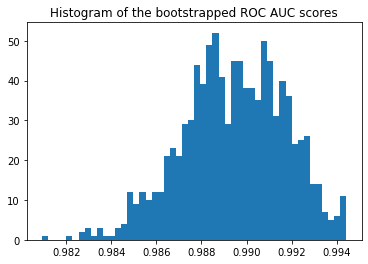

Confidence interval for the score: [0.99 - 0.99]
Original ROC area: 0.77
Bootstrap #1 ROC area: 0.73
Bootstrap #2 ROC area: 0.78
Bootstrap #3 ROC area: 0.74
Bootstrap #4 ROC area: 0.84
Bootstrap #5 ROC area: 0.74
Bootstrap #6 ROC area: 0.75
Bootstrap #7 ROC area: 0.76
Bootstrap #8 ROC area: 0.71
Bootstrap #9 ROC area: 0.75
Bootstrap #10 ROC area: 0.74
Bootstrap #11 ROC area: 0.76
Bootstrap #12 ROC area: 0.81
Bootstrap #13 ROC area: 0.77
Bootstrap #14 ROC area: 0.78
Bootstrap #15 ROC area: 0.74
Bootstrap #16 ROC area: 0.75
Bootstrap #17 ROC area: 0.86
Bootstrap #18 ROC area: 0.86
Bootstrap #19 ROC area: 0.74
Bootstrap #20 ROC area: 0.80
Bootstrap #21 ROC area: 0.75
Bootstrap #22 ROC area: 0.73
Bootstrap #23 ROC area: 0.78
Bootstrap #24 ROC area: 0.68
Bootstrap #25 ROC area: 0.78
Bootstrap #26 ROC area: 0.81
Bootstrap #27 ROC area: 0.72
Bootstrap #28 ROC area: 0.78
Bootstrap #29 ROC area: 0.77
Bootstrap #30 ROC area: 0.70
Bootstrap #31 ROC area: 0.73
Bootstrap #32 ROC area: 0.73
Bootstra

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 

Bootstrap #118 ROC area: 0.80
Bootstrap #119 ROC area: 0.77
Bootstrap #120 ROC area: 0.71
Bootstrap #121 ROC area: 0.78
Bootstrap #122 ROC area: 0.81
Bootstrap #123 ROC area: 0.78
Bootstrap #124 ROC area: 0.84
Bootstrap #125 ROC area: 0.78
Bootstrap #126 ROC area: 0.80
Bootstrap #127 ROC area: 0.80
Bootstrap #128 ROC area: 0.80
Bootstrap #129 ROC area: 0.84
Bootstrap #130 ROC area: 0.74
Bootstrap #131 ROC area: 0.80
Bootstrap #132 ROC area: 0.81
Bootstrap #133 ROC area: 0.78
Bootstrap #134 ROC area: 0.83
Bootstrap #135 ROC area: 0.77
Bootstrap #136 ROC area: 0.76
Bootstrap #137 ROC area: 0.76
Bootstrap #138 ROC area: 0.78
Bootstrap #139 ROC area: 0.69
Bootstrap #140 ROC area: 0.81
Bootstrap #141 ROC area: 0.82
Bootstrap #142 ROC area: 0.77
Bootstrap #143 ROC area: 0.74
Bootstrap #144 ROC area: 0.72
Bootstrap #145 ROC area: 0.83
Bootstrap #146 ROC area: 0.77
Bootstrap #147 ROC area: 0.78
Bootstrap #148 ROC area: 0.76
Bootstrap #149 ROC area: 0.71
Bootstrap #150 ROC area: 0.74
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 


Bootstrap #246 ROC area: 0.79
Bootstrap #247 ROC area: 0.64
Bootstrap #248 ROC area: 0.82
Bootstrap #249 ROC area: 0.83
Bootstrap #250 ROC area: 0.81
Bootstrap #251 ROC area: 0.79
Bootstrap #252 ROC area: 0.71
Bootstrap #253 ROC area: 0.73
Bootstrap #254 ROC area: 0.77
Bootstrap #255 ROC area: 0.72
Bootstrap #256 ROC area: 0.80
Bootstrap #257 ROC area: 0.87
Bootstrap #258 ROC area: 0.69
Bootstrap #259 ROC area: 0.76
Bootstrap #260 ROC area: 0.68
Bootstrap #261 ROC area: 0.70
Bootstrap #262 ROC area: 0.80
Bootstrap #263 ROC area: 0.86
Bootstrap #264 ROC area: 0.76
Bootstrap #265 ROC area: 0.77
Bootstrap #266 ROC area: 0.71
Bootstrap #267 ROC area: 0.82
Bootstrap #268 ROC area: 0.79
Bootstrap #269 ROC area: 0.71
Bootstrap #270 ROC area: 0.77
Bootstrap #271 ROC area: 0.82
Bootstrap #272 ROC area: 0.84
Bootstrap #273 ROC area: 0.70
Bootstrap #274 ROC area: 0.71
Bootstrap #275 ROC area: 0.79
Bootstrap #276 ROC area: 0.69
Bootstrap #277 ROC area: 0.84
Bootstrap #278 ROC area: 0.81
Bootstrap

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 

Bootstrap #376 ROC area: 0.66
Bootstrap #377 ROC area: 0.80
Bootstrap #378 ROC area: 0.73
Bootstrap #379 ROC area: 0.82
Bootstrap #380 ROC area: 0.76
Bootstrap #381 ROC area: 0.75
Bootstrap #382 ROC area: 0.71
Bootstrap #383 ROC area: 0.83
Bootstrap #384 ROC area: 0.83
Bootstrap #385 ROC area: 0.85
Bootstrap #386 ROC area: 0.76
Bootstrap #387 ROC area: 0.81
Bootstrap #388 ROC area: 0.73
Bootstrap #389 ROC area: 0.68
Bootstrap #390 ROC area: 0.82
Bootstrap #391 ROC area: 0.72
Bootstrap #392 ROC area: 0.74
Bootstrap #393 ROC area: 0.69
Bootstrap #394 ROC area: 0.83
Bootstrap #395 ROC area: 0.69
Bootstrap #396 ROC area: 0.78
Bootstrap #397 ROC area: 0.77
Bootstrap #398 ROC area: 0.82
Bootstrap #399 ROC area: 0.78
Bootstrap #400 ROC area: 0.76
Bootstrap #401 ROC area: 0.77
Bootstrap #402 ROC area: 0.74
Bootstrap #403 ROC area: 0.73
Bootstrap #404 ROC area: 0.75
Bootstrap #405 ROC area: 0.76
Bootstrap #406 ROC area: 0.73
Bootstrap #407 ROC area: 0.80
Bootstrap #408 ROC area: 0.78
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 

Bootstrap #510 ROC area: 0.64
Bootstrap #511 ROC area: 0.80
Bootstrap #512 ROC area: 0.70
Bootstrap #513 ROC area: 0.73
Bootstrap #514 ROC area: 0.82
Bootstrap #515 ROC area: 0.78
Bootstrap #516 ROC area: 0.72
Bootstrap #517 ROC area: 0.73
Bootstrap #518 ROC area: 0.73
Bootstrap #519 ROC area: 0.75
Bootstrap #520 ROC area: 0.83
Bootstrap #521 ROC area: 0.74
Bootstrap #522 ROC area: 0.73
Bootstrap #523 ROC area: 0.80
Bootstrap #524 ROC area: 0.68
Bootstrap #525 ROC area: 0.73
Bootstrap #526 ROC area: 0.81
Bootstrap #527 ROC area: 0.80
Bootstrap #528 ROC area: 0.84
Bootstrap #529 ROC area: 0.67
Bootstrap #530 ROC area: 0.69
Bootstrap #531 ROC area: 0.70
Bootstrap #532 ROC area: 0.81
Bootstrap #533 ROC area: 0.84
Bootstrap #534 ROC area: 0.80
Bootstrap #535 ROC area: 0.80
Bootstrap #536 ROC area: 0.78
Bootstrap #537 ROC area: 0.84
Bootstrap #538 ROC area: 0.76
Bootstrap #539 ROC area: 0.77
Bootstrap #540 ROC area: 0.87
Bootstrap #541 ROC area: 0.74
Bootstrap #542 ROC area: 0.77
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 


Bootstrap #641 ROC area: 0.77
Bootstrap #642 ROC area: 0.83
Bootstrap #643 ROC area: 0.73
Bootstrap #644 ROC area: 0.77
Bootstrap #645 ROC area: 0.71
Bootstrap #646 ROC area: 0.80
Bootstrap #647 ROC area: 0.75
Bootstrap #648 ROC area: 0.81
Bootstrap #649 ROC area: 0.74
Bootstrap #650 ROC area: 0.71
Bootstrap #651 ROC area: 0.67
Bootstrap #652 ROC area: 0.77
Bootstrap #653 ROC area: 0.78
Bootstrap #654 ROC area: 0.79
Bootstrap #655 ROC area: 0.76
Bootstrap #656 ROC area: 0.71
Bootstrap #657 ROC area: 0.78
Bootstrap #658 ROC area: 0.81
Bootstrap #659 ROC area: 0.88
Bootstrap #660 ROC area: 0.86
Bootstrap #661 ROC area: 0.79
Bootstrap #662 ROC area: 0.80
Bootstrap #663 ROC area: 0.71
Bootstrap #664 ROC area: 0.73
Bootstrap #665 ROC area: 0.81
Bootstrap #666 ROC area: 0.78
Bootstrap #667 ROC area: 0.76
Bootstrap #668 ROC area: 0.75
Bootstrap #669 ROC area: 0.80
Bootstrap #670 ROC area: 0.80
Bootstrap #671 ROC area: 0.77
Bootstrap #672 ROC area: 0.75
Bootstrap #673 ROC area: 0.70
Bootstrap

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 


Bootstrap #770 ROC area: 0.77
Bootstrap #771 ROC area: 0.81
Bootstrap #772 ROC area: 0.77
Bootstrap #773 ROC area: 0.81
Bootstrap #774 ROC area: 0.82
Bootstrap #775 ROC area: 0.85
Bootstrap #776 ROC area: 0.79
Bootstrap #777 ROC area: 0.81
Bootstrap #778 ROC area: 0.82
Bootstrap #779 ROC area: 0.86
Bootstrap #780 ROC area: 0.75
Bootstrap #781 ROC area: 0.74
Bootstrap #782 ROC area: 0.74
Bootstrap #783 ROC area: 0.73
Bootstrap #784 ROC area: 0.79
Bootstrap #785 ROC area: 0.73
Bootstrap #786 ROC area: 0.78
Bootstrap #787 ROC area: 0.75
Bootstrap #788 ROC area: 0.86
Bootstrap #789 ROC area: 0.80
Bootstrap #790 ROC area: 0.82
Bootstrap #791 ROC area: 0.76
Bootstrap #792 ROC area: 0.75
Bootstrap #793 ROC area: 0.74
Bootstrap #794 ROC area: 0.75
Bootstrap #795 ROC area: 0.80
Bootstrap #796 ROC area: 0.81
Bootstrap #797 ROC area: 0.66
Bootstrap #798 ROC area: 0.87
Bootstrap #799 ROC area: 0.73
Bootstrap #800 ROC area: 0.76
Bootstrap #801 ROC area: 0.76
Bootstrap #802 ROC area: 0.72
Bootstrap

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 

Bootstrap #911 ROC area: 0.73
Bootstrap #912 ROC area: 0.79
Bootstrap #913 ROC area: 0.83
Bootstrap #914 ROC area: 0.81
Bootstrap #915 ROC area: 0.75
Bootstrap #916 ROC area: 0.80
Bootstrap #917 ROC area: 0.77
Bootstrap #918 ROC area: 0.75
Bootstrap #919 ROC area: 0.77
Bootstrap #920 ROC area: 0.71
Bootstrap #921 ROC area: 0.79
Bootstrap #922 ROC area: 0.74
Bootstrap #923 ROC area: 0.81
Bootstrap #924 ROC area: 0.78
Bootstrap #925 ROC area: 0.78
Bootstrap #926 ROC area: 0.74
Bootstrap #927 ROC area: 0.75
Bootstrap #928 ROC area: 0.82
Bootstrap #929 ROC area: 0.75
Bootstrap #930 ROC area: 0.78
Bootstrap #931 ROC area: 0.77
Bootstrap #932 ROC area: 0.78
Bootstrap #933 ROC area: 0.77
Bootstrap #934 ROC area: 0.77
Bootstrap #935 ROC area: 0.74
Bootstrap #936 ROC area: 0.75
Bootstrap #937 ROC area: 0.79
Bootstrap #938 ROC area: 0.78
Bootstrap #939 ROC area: 0.66
Bootstrap #940 ROC area: 0.77
Bootstrap #941 ROC area: 0.71
Bootstrap #942 ROC area: 0.84
Bootstrap #943 ROC area: 0.83
Bootstrap 

<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-6-1393675ce4ff>:17: DeprecationWarning: 

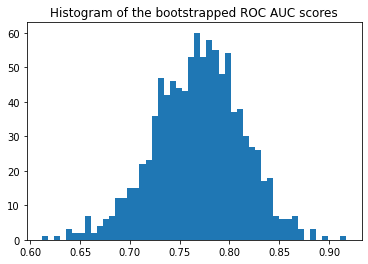

Confidence interval for the score: [0.69 - 0.84]
Wall time: 8.34 s


In [8]:
%%time
test_auc_list = []; train_auc_list = []; train_auc_CV_list = []; validation_auc_list = []
test_auc_liebiao = []; train_auc_liebiao = []; train_auc_CV_liebiao = []; validation_auc_liebiao = [] 
feature_importance_list = []
index_train_list = []; index_test_list = []; index_validation_list = []
index_train_liebiao = []; index_test_liebiao = []; index_validation_liebiao = []

for i in range(len(type_name)):
    #############################第一次建模
    ####### 准备数据
    train_pos = data_train[data_train['Stage'] == type_name[i]]
    train_neg = data_train[data_train['Stage'] != type_name[i]]; train_neg = train_neg[train_neg['Stage'] != 'n.a.']
    test_pos = data_test[data_test['Stage'] == type_name[i]]
    test_neg = data_test[data_test['Stage'] != type_name[i]]; test_neg = test_neg[test_neg['Stage'] != 'n.a.']
    validation_pos = data_validation[data_validation['Stage'] == type_name[i]]
    validation_neg = data_validation[data_validation['Stage'] != type_name[i]]; validation_neg = validation_neg[validation_neg['Stage'] != 'n.a.']

    train_pos['outcome'] = [1 for i in range(train_pos.shape[0])]
    train_neg['outcome'] = [0 for i in range(train_neg.shape[0])]
    test_pos['outcome'] = [1 for i in range(test_pos.shape[0])]
    test_neg['outcome'] = [0 for i in range(test_neg.shape[0])]
    validation_pos['outcome'] = [1 for i in range(validation_pos.shape[0])]
    validation_neg['outcome'] = [0 for i in range(validation_neg.shape[0])]

    trainset = pd.concat([train_pos, train_neg], axis=0) # 拼接
    testset = pd.concat([test_pos, test_neg], axis=0) # 拼接
    X_train = trainset[feature_total]
    X_test = testset[feature_total]
    y_train = trainset['outcome']
    y_test = testset['outcome']
    validationset = pd.concat([validation_pos, validation_neg], axis=0) # 拼接
    X_validation = validationset[feature_total]
    y_validation = validationset['outcome']

    # 随机数
    seed = 123

    ####### 过采样
    over_sample = SMOTE(sampling_strategy='minority', random_state=seed)
    X_train, y_train = over_sample.fit_resample(X_train, y_train)
    X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=seed) # 打乱
    # 不再标准化
    # 保存标准化+过采样的全特征数据集
    X_df_train = pd.DataFrame(X_train, columns=feature_total)
    X_df_test = pd.DataFrame(X_test, columns=feature_total)
    X_df_validation = pd.DataFrame(X_validation, columns=feature_total)

    ####### 方差筛选
    selector = VarianceThreshold(threshold=2.5)
    selector.fit_transform(X_train, y_train)
    feature_VarianceThreshold = selector.get_feature_names_out(input_features=feature_total)
    feature_VarianceThreshold.tolist()
    print(len(feature_VarianceThreshold))

    X_train = np.array(X_df_train[feature_VarianceThreshold])
    X_test = np.array(X_df_test[feature_VarianceThreshold])
    X_validation = np.array(X_df_validation[feature_VarianceThreshold])

    # 待用数据集转为np
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    X_validation = np.array(X_validation)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_validation = np.array(y_validation)
    

    ######## XGB建模
    model_XGB = XGBClassifier(n_estimators=40, max_depth=1, subsample=0.9, 
                          colsample_bytree=1, reg_alpha= 0.1, 
                          objective= 'binary:logistic', nthread=8,
                        scale_pos_weight=1, seed=123)
    model_XGB.fit(X_train, y_train)  

    test_auc_XGB = metrics.roc_auc_score(y_test, model_XGB.predict_proba(X_test)[:,1])
    train_auc_XGB = metrics.roc_auc_score(y_train, model_XGB.predict_proba(X_train)[:,1])
    validation_auc_XGB = metrics.roc_auc_score(y_validation, model_XGB.predict_proba(X_validation)[:,1])
    train_auc_XGB_CV = cross_val_score(model_XGB, X_train, y_train, cv=10, scoring='roc_auc')
    train_auc_XGB_CV = train_auc_XGB_CV.mean()
    
    test_auc_list.append(test_auc_XGB); train_auc_list.append(train_auc_XGB)
    train_auc_CV_list.append(train_auc_XGB_CV); validation_auc_list.append(validation_auc_XGB)
    
    ####### 重要性
    X_columns = feature_VarianceThreshold
    importance_XGB = model_XGB.feature_importances_
    imp_result = np.argsort(importance_XGB)[::-1][:]
    for j in range(len(imp_result)):
        print("%2d. %-*s %f" % (j + 1, 30, X_columns[imp_result[j]], importance_XGB[imp_result[j]]))
    X_columns_XGB = [X_columns[j] for j in imp_result]
    col_name = []
    imp_num = []
    for j in range(len(imp_result)):
        col_name.append(X_columns[imp_result[j]])
        imp_num.append(importance_XGB[imp_result[j]])
    col_name = np.array(col_name)
    col_name = col_name[:,np.newaxis]
    imp_num = np.array(imp_num)
    imp_num = imp_num[:,np.newaxis]
    feature_importance_XGB = np.hstack([col_name, imp_num])
    if i == 0:
        feature_importance_np = feature_importance_XGB[:100,:]
    else:
        feature_importance_np = np.hstack([feature_importance_np, feature_importance_XGB[:100,:]])
    
    feature_importance_list.append(feature_importance_XGB)
    
    '''
    ###### 置信区间
    confidence_interval_test_XGB = Confidence_Interval(model_XGB.predict_proba(X_test)[:,1], y_test)
    confidence_interval_train_XGB = Confidence_Interval(model_XGB.predict_proba(X_train)[:,1], y_train)

    ###### 其他指标
    f1_test_XGB, f2_test_XGB, f05_test_XGB, precision_test_XGB, recall_test_XGB, PPV_test_XGB, NPV_test_XGB, FAR_test_XGB, accuracy_test_XGB, specificity_test_XGB = sk_matrix(model_XGB, y_test, model_XGB.predict(X_test))
    f1_train_XGB, f2_train_XGB, f05_train_XGB, precision_train_XGB, recall_train_XGB, PPV_train_XGB, NPV_train_XGB, FAR_train_XGB, accuracy_train_XGB, specificity_train_XGB = sk_matrix(model_XGB, y_train, model_XGB.predict(X_train))
    index_test = [f1_test_XGB, f2_test_XGB, f05_test_XGB, precision_test_XGB, recall_test_XGB, PPV_test_XGB, NPV_test_XGB, FAR_test_XGB, accuracy_test_XGB, specificity_test_XGB]
    index_train = [f1_train_XGB, f2_train_XGB, f05_train_XGB, precision_train_XGB, recall_train_XGB, PPV_train_XGB, NPV_train_XGB, FAR_train_XGB, accuracy_train_XGB, specificity_train_XGB]
    
    index_test_list.append(index_test); index_train_list.append(index_train)
    '''
    #############################第二次建模
    ####### 准备数据
    n_feature = 25
    X_train = np.array(X_df_train[feature_importance_XGB[:n_feature, 0]])
    X_test = np.array(X_df_test[feature_importance_XGB[:n_feature, 0]])
    X_validation = np.array(X_df_validation[feature_importance_XGB[:n_feature, 0]])

    # 待用数据集转为np
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    X_validation = np.array(X_validation)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_validation = np.array(y_validation)

    ####### 第二次XGB建模
    model_XGB = XGBClassifier(n_estimators=40, max_depth=1, subsample=0.9, 
                          colsample_bytree=1, reg_alpha= 0.1, 
                          objective= 'binary:logistic', nthread=8,
                        scale_pos_weight=1, seed=123)
    model_XGB.fit(X_train, y_train)  

    test_auc_XGB = metrics.roc_auc_score(y_test, model_XGB.predict_proba(X_test)[:,1])
    train_auc_XGB = metrics.roc_auc_score(y_train, model_XGB.predict_proba(X_train)[:,1])
    validation_auc_XGB = metrics.roc_auc_score(y_validation, model_XGB.predict_proba(X_validation)[:,1])
    train_auc_XGB_CV = cross_val_score(model_XGB, X_train, y_train, cv=10, scoring='roc_auc')
    train_auc_XGB_CV = train_auc_XGB_CV.mean()
    
    ###### 置信区间
    confidence_interval_test_XGB = Confidence_Interval(model_XGB.predict_proba(X_test)[:,1], y_test)
    confidence_interval_train_XGB = Confidence_Interval(model_XGB.predict_proba(X_train)[:,1], y_train)
    confidence_interval_validation_XGB = Confidence_Interval(model_XGB.predict_proba(X_validation)[:,1], y_validation)
    
    train_auc_XGB = str(round(train_auc_XGB, 2)) + ' ' + confidence_interval_train_XGB
    test_auc_XGB = str(round(test_auc_XGB, 2)) + ' ' + confidence_interval_test_XGB
    validation_auc_XGB = str(round(validation_auc_XGB, 2)) + ' ' + confidence_interval_validation_XGB
    
    test_auc_liebiao.append(test_auc_XGB); train_auc_liebiao.append(train_auc_XGB)
    train_auc_CV_liebiao.append(train_auc_XGB_CV); validation_auc_liebiao.append(validation_auc_XGB)

    '''
    ###### 其他指标
    f1_test_XGB, f2_test_XGB, f05_test_XGB, precision_test_XGB, recall_test_XGB, PPV_test_XGB, NPV_test_XGB, FAR_test_XGB, accuracy_test_XGB, specificity_test_XGB = sk_matrix(model_XGB, y_test, model_XGB.predict(X_test))
    f1_train_XGB, f2_train_XGB, f05_train_XGB, precision_train_XGB, recall_train_XGB, PPV_train_XGB, NPV_train_XGB, FAR_train_XGB, accuracy_train_XGB, specificity_train_XGB = sk_matrix(model_XGB, y_train, model_XGB.predict(X_train))
    index_test = [f1_test_XGB, f2_test_XGB, f05_test_XGB, precision_test_XGB, recall_test_XGB, PPV_test_XGB, NPV_test_XGB, FAR_test_XGB, accuracy_test_XGB, specificity_test_XGB]
    index_train = [f1_train_XGB, f2_train_XGB, f05_train_XGB, precision_train_XGB, recall_train_XGB, PPV_train_XGB, NPV_train_XGB, FAR_train_XGB, accuracy_train_XGB, specificity_train_XGB]
    f1_validation_XGB, f2_validation_XGB, f05_validation_XGB, precision_validation_XGB, recall_validation_XGB, PPV_validation_XGB, NPV_validation_XGB, FAR_validation_XGB, accuracy_validation_XGB, specificity_validation_XGB = sk_matrix(model_XGB, y_validation, model_XGB.predict(X_validation))    
    index_validation = [f1_validation_XGB, f2_validation_XGB, f05_validation_XGB, precision_validation_XGB, recall_validation_XGB, PPV_validation_XGB, NPV_validation_XGB, FAR_validation_XGB, accuracy_validation_XGB, specificity_validation_XGB]
    
    index_train_liebiao.append(index_test); index_test_liebiao.append(index_train); index_validation_liebiao.append(index_validation)
    break
    '''
    break

In [32]:
feature_importance_np = np.array(feature_importance_np)
feature_importance_np = pd.DataFrame(feature_importance_np, columns=[['I', ' ', 'II', ' ', 'III', ' ', 'IV', ' ']])
feature_importance_np.to_csv('feature_stage.csv')

In [76]:
index_1000 = np.hstack([np.array(train_auc_list).reshape(-1,1), np.array(train_auc_CV_list).reshape(-1,1), np.array(test_auc_list).reshape(-1,1), np.array(validation_auc_list).reshape(-1,1)])
index_25 = np.hstack([np.array(train_auc_liebiao).reshape(-1,1), np.array(train_auc_CV_liebiao).reshape(-1,1), np.array(test_auc_liebiao).reshape(-1,1), np.array(validation_auc_liebiao).reshape(-1,1)])
index_total = np.hstack([index_1000, index_25])
index_name = np.array(['train_1000', 'train_CV_1000', 'test_1000', 'validation_1000', 'train_25', 'train_CV_25', 'test_25', 'validation_25'])

index_total = np.vstack([index_name, index_total])
index_total = np.hstack([np.array(['type']+type_name).reshape(-1,1), index_total])

index_total = pd.DataFrame(index_total)
index_total.to_csv('过采样_stage.csv')

In [17]:
# 基因名称
feature_total = data_train.columns[1:].tolist()
feature_total = feature_total[:-4]
# 结局
outcome_variable = 'type'

In [18]:
# 获取结局类别
from collections import Counter
b = np.array(data_train[outcome_variable])
b = b.tolist()
b = dict(Counter(b)) # 列表计数
type_name = []
for key, value in b.items():
    type_name.append(key)
print(type_name)

['Glioma', 'Non-small-cell lung cancer', 'Pancreatic cancer', 'Breast cancer', 'Head and neck cancer', 'Melanoma', 'Ovarian cancer', 'Colorectal cancer', 'Multiple Myeloma', 'Sarcoma', 'Cholangiocarcinoma', 'Hepatocellular carcinoma', 'Endometrial cancer', 'Esophageal carcinoma', 'Lymphoma', 'Prostate cancer', 'Renal cell cancer', 'Urothelial cancer']


In [19]:
# 检查结局分类
print(data_train.type.value_counts())
print(data_test.type.value_counts())
print(data_validation.type.value_counts())

Non-small-cell lung cancer    207
Ovarian cancer                 59
Pancreatic cancer              56
Glioma                         54
Breast cancer                  44
Colorectal cancer              35
Head and neck cancer           34
Cholangiocarcinoma             32
Melanoma                       23
Endometrial cancer             18
Sarcoma                        17
Urothelial cancer              14
Renal cell cancer              14
Multiple Myeloma               12
Hepatocellular carcinoma       10
Prostate cancer                10
Lymphoma                        8
Esophageal carcinoma            5
Name: type, dtype: int64
Non-small-cell lung cancer    100
Head and neck cancer           29
Pancreatic cancer              24
Glioma                         24
Ovarian cancer                 23
Colorectal cancer              20
Cholangiocarcinoma             19
Breast cancer                  17
Melanoma                       16
Sarcoma                        14
Endometrial cancer     

<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


974
[15:16:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 1. DDX3Y                          0.129402
 2. FKBP5                          0.103880
 3. IL1R2                          0.086617
 4. HSD17B3                        0.082439
 5. WFDC1                          0.054496
 6. KDM5D                          0.047281
 7. C1orf87                        0.047013
 8. MTATP6P1                       0.031394
 9. LTF                            0.023407
10. HBD                            0.021269
11. GSTM1                          0.020682
12. RBM6                           0.019466
13. RPS4Y1                         0.016535
14. MTRNR2L8                       0.016505
15. KLHDC8B                        0.015710
16. CADM2                     

D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:

[15:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:

[15:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:

[15:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Original ROC area: 0.88

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar


Bootstrap #1 ROC area: 0.89
Bootstrap #2 ROC area: 0.88
Bootstrap #3 ROC area: 0.91
Bootstrap #4 ROC area: 0.90
Bootstrap #5 ROC area: 0.84
Bootstrap #6 ROC area: 0.88
Bootstrap #7 ROC area: 0.89
Bootstrap #8 ROC area: 0.90
Bootstrap #9 ROC area: 0.84
Bootstrap #10 ROC area: 0.88
Bootstrap #11 ROC area: 0.89
Bootstrap #12 ROC area: 0.86
Bootstrap #13 ROC area: 0.86
Bootstrap #14 ROC area: 0.86
Bootstrap #15 ROC area: 0.92
Bootstrap #16 ROC area: 0.77
Bootstrap #17 ROC area: 0.85
Bootstrap #18 ROC area: 0.91
Bootstrap #19 ROC area: 0.87
Bootstrap #20 ROC area: 0.88
Bootstrap #21 ROC area: 0.86
Bootstrap #22 ROC area: 0.90
Bootstrap #23 ROC area: 0.85
Bootstrap #24 ROC area: 0.87
Bootstrap #25 ROC area: 0.85
Bootstrap #26 ROC area: 0.87
Bootstrap #27 ROC area: 0.91
Bootstrap #28 ROC area: 0.93
Bootstrap #29 ROC area: 0.94
Bootstrap #30 ROC area: 0.87
Bootstrap #31 ROC area: 0.88
Bootstrap #32 ROC area: 0.87
Bootstrap #33 ROC area: 0.86
Bootstrap #34 ROC area: 0.92
Bootstrap #35 ROC area

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar


Bootstrap #71 ROC area: 0.81
Bootstrap #72 ROC area: 0.91
Bootstrap #73 ROC area: 0.86
Bootstrap #74 ROC area: 0.85
Bootstrap #75 ROC area: 0.87
Bootstrap #76 ROC area: 0.90
Bootstrap #77 ROC area: 0.87
Bootstrap #78 ROC area: 0.91
Bootstrap #79 ROC area: 0.84
Bootstrap #80 ROC area: 0.80
Bootstrap #81 ROC area: 0.89
Bootstrap #82 ROC area: 0.87
Bootstrap #83 ROC area: 0.84
Bootstrap #84 ROC area: 0.86
Bootstrap #85 ROC area: 0.88
Bootstrap #86 ROC area: 0.86
Bootstrap #87 ROC area: 0.88
Bootstrap #88 ROC area: 0.82
Bootstrap #89 ROC area: 0.81
Bootstrap #90 ROC area: 0.84
Bootstrap #91 ROC area: 0.92
Bootstrap #92 ROC area: 0.86
Bootstrap #93 ROC area: 0.85
Bootstrap #94 ROC area: 0.90
Bootstrap #95 ROC area: 0.88
Bootstrap #96 ROC area: 0.90
Bootstrap #97 ROC area: 0.84
Bootstrap #98 ROC area: 0.90
Bootstrap #99 ROC area: 0.79
Bootstrap #100 ROC area: 0.87
Bootstrap #101 ROC area: 0.83
Bootstrap #102 ROC area: 0.85
Bootstrap #103 ROC area: 0.86
Bootstrap #104 ROC area: 0.88
Bootstra

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar


Bootstrap #162 ROC area: 0.88
Bootstrap #163 ROC area: 0.89
Bootstrap #164 ROC area: 0.86
Bootstrap #165 ROC area: 0.85
Bootstrap #166 ROC area: 0.96
Bootstrap #167 ROC area: 0.77
Bootstrap #168 ROC area: 0.94
Bootstrap #169 ROC area: 0.90
Bootstrap #170 ROC area: 0.85
Bootstrap #171 ROC area: 0.89
Bootstrap #172 ROC area: 0.90
Bootstrap #173 ROC area: 0.88
Bootstrap #174 ROC area: 0.82
Bootstrap #175 ROC area: 0.82
Bootstrap #176 ROC area: 0.94
Bootstrap #177 ROC area: 0.85
Bootstrap #178 ROC area: 0.94
Bootstrap #179 ROC area: 0.89
Bootstrap #180 ROC area: 0.92
Bootstrap #181 ROC area: 0.84
Bootstrap #182 ROC area: 0.88
Bootstrap #183 ROC area: 0.90
Bootstrap #184 ROC area: 0.78
Bootstrap #185 ROC area: 0.94
Bootstrap #186 ROC area: 0.94
Bootstrap #187 ROC area: 0.95
Bootstrap #188 ROC area: 0.90
Bootstrap #189 ROC area: 0.88
Bootstrap #190 ROC area: 0.81
Bootstrap #191 ROC area: 0.91
Bootstrap #192 ROC area: 0.90
Bootstrap #193 ROC area: 0.94
Bootstrap #194 ROC area: 0.93
Bootstrap

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar


Bootstrap #259 ROC area: 0.89
Bootstrap #260 ROC area: 0.93
Bootstrap #261 ROC area: 0.92
Bootstrap #262 ROC area: 0.91
Bootstrap #263 ROC area: 0.86
Bootstrap #264 ROC area: 0.89
Bootstrap #265 ROC area: 0.84
Bootstrap #266 ROC area: 0.86
Bootstrap #267 ROC area: 0.87
Bootstrap #268 ROC area: 0.85
Bootstrap #269 ROC area: 0.88
Bootstrap #270 ROC area: 0.89
Bootstrap #271 ROC area: 0.88
Bootstrap #272 ROC area: 0.83
Bootstrap #273 ROC area: 0.79
Bootstrap #274 ROC area: 0.90
Bootstrap #275 ROC area: 0.90
Bootstrap #276 ROC area: 0.94
Bootstrap #277 ROC area: 0.84
Bootstrap #278 ROC area: 0.88
Bootstrap #279 ROC area: 0.88
Bootstrap #280 ROC area: 0.93
Bootstrap #281 ROC area: 0.95
Bootstrap #282 ROC area: 0.94
Bootstrap #283 ROC area: 0.96
Bootstrap #284 ROC area: 0.88
Bootstrap #285 ROC area: 0.83
Bootstrap #286 ROC area: 0.89
Bootstrap #287 ROC area: 0.87
Bootstrap #288 ROC area: 0.84
Bootstrap #289 ROC area: 0.90
Bootstrap #290 ROC area: 0.89
Bootstrap #291 ROC area: 0.89
Bootstrap

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar

Bootstrap #488 ROC area: 0.88
Bootstrap #489 ROC area: 0.86
Bootstrap #490 ROC area: 0.94
Bootstrap #491 ROC area: 0.94
Bootstrap #492 ROC area: 0.83
Bootstrap #493 ROC area: 0.89
Bootstrap #494 ROC area: 0.86
Bootstrap #495 ROC area: 0.84
Bootstrap #496 ROC area: 0.85
Bootstrap #497 ROC area: 0.89
Bootstrap #498 ROC area: 0.88
Bootstrap #499 ROC area: 0.85
Bootstrap #500 ROC area: 0.87
Bootstrap #501 ROC area: 0.95
Bootstrap #502 ROC area: 0.90
Bootstrap #503 ROC area: 0.85
Bootstrap #504 ROC area: 0.89
Bootstrap #505 ROC area: 0.85
Bootstrap #506 ROC area: 0.92
Bootstrap #507 ROC area: 0.90
Bootstrap #508 ROC area: 0.92
Bootstrap #509 ROC area: 0.89
Bootstrap #510 ROC area: 0.86
Bootstrap #511 ROC area: 0.90
Bootstrap #512 ROC area: 0.88
Bootstrap #513 ROC area: 0.87
Bootstrap #514 ROC area: 0.86
Bootstrap #515 ROC area: 0.90
Bootstrap #516 ROC area: 0.96
Bootstrap #517 ROC area: 0.83
Bootstrap #518 ROC area: 0.87
Bootstrap #519 ROC area: 0.88
Bootstrap #520 ROC area: 0.82
Bootstrap 

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar


Bootstrap #601 ROC area: 0.95
Bootstrap #602 ROC area: 0.88
Bootstrap #603 ROC area: 0.91
Bootstrap #604 ROC area: 0.85
Bootstrap #605 ROC area: 0.85
Bootstrap #606 ROC area: 0.88
Bootstrap #607 ROC area: 0.88
Bootstrap #608 ROC area: 0.88
Bootstrap #609 ROC area: 0.88
Bootstrap #610 ROC area: 0.84
Bootstrap #611 ROC area: 0.93
Bootstrap #612 ROC area: 0.84
Bootstrap #613 ROC area: 0.88
Bootstrap #614 ROC area: 0.90
Bootstrap #615 ROC area: 0.85
Bootstrap #616 ROC area: 0.92
Bootstrap #617 ROC area: 0.89
Bootstrap #618 ROC area: 0.89
Bootstrap #619 ROC area: 0.91
Bootstrap #620 ROC area: 0.87
Bootstrap #621 ROC area: 0.90
Bootstrap #622 ROC area: 0.81
Bootstrap #623 ROC area: 0.93
Bootstrap #624 ROC area: 0.86
Bootstrap #625 ROC area: 0.92
Bootstrap #626 ROC area: 0.93
Bootstrap #627 ROC area: 0.89
Bootstrap #628 ROC area: 0.90
Bootstrap #629 ROC area: 0.86
Bootstrap #630 ROC area: 0.94
Bootstrap #631 ROC area: 0.87
Bootstrap #632 ROC area: 0.90
Bootstrap #633 ROC area: 0.93
Bootstrap

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar


Bootstrap #722 ROC area: 0.82
Bootstrap #723 ROC area: 0.87
Bootstrap #724 ROC area: 0.83
Bootstrap #725 ROC area: 0.90
Bootstrap #726 ROC area: 0.89
Bootstrap #727 ROC area: 0.93
Bootstrap #728 ROC area: 0.94
Bootstrap #729 ROC area: 0.87
Bootstrap #730 ROC area: 0.89
Bootstrap #731 ROC area: 0.92
Bootstrap #732 ROC area: 0.91
Bootstrap #733 ROC area: 0.90
Bootstrap #734 ROC area: 0.85
Bootstrap #735 ROC area: 0.91
Bootstrap #736 ROC area: 0.85
Bootstrap #737 ROC area: 0.88
Bootstrap #738 ROC area: 0.88
Bootstrap #739 ROC area: 0.81
Bootstrap #740 ROC area: 0.96
Bootstrap #741 ROC area: 0.93
Bootstrap #742 ROC area: 0.89
Bootstrap #743 ROC area: 0.89
Bootstrap #744 ROC area: 0.90
Bootstrap #745 ROC area: 0.89
Bootstrap #746 ROC area: 0.89
Bootstrap #747 ROC area: 0.88
Bootstrap #748 ROC area: 0.90
Bootstrap #749 ROC area: 0.92
Bootstrap #750 ROC area: 0.93
Bootstrap #751 ROC area: 0.90
Bootstrap #752 ROC area: 0.92
Bootstrap #753 ROC area: 0.87
Bootstrap #754 ROC area: 0.86
Bootstrap

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar


Bootstrap #847 ROC area: 0.91
Bootstrap #848 ROC area: 0.89
Bootstrap #849 ROC area: 0.87
Bootstrap #850 ROC area: 0.87
Bootstrap #851 ROC area: 0.88
Bootstrap #852 ROC area: 0.84
Bootstrap #853 ROC area: 0.88
Bootstrap #854 ROC area: 0.93
Bootstrap #855 ROC area: 0.91
Bootstrap #856 ROC area: 0.89
Bootstrap #857 ROC area: 0.89
Bootstrap #858 ROC area: 0.88
Bootstrap #859 ROC area: 0.79
Bootstrap #860 ROC area: 0.85
Bootstrap #861 ROC area: 0.90
Bootstrap #862 ROC area: 0.88
Bootstrap #863 ROC area: 0.89
Bootstrap #864 ROC area: 0.89
Bootstrap #865 ROC area: 0.88
Bootstrap #866 ROC area: 0.80
Bootstrap #867 ROC area: 0.88
Bootstrap #868 ROC area: 0.86
Bootstrap #869 ROC area: 0.91
Bootstrap #870 ROC area: 0.84
Bootstrap #871 ROC area: 0.81
Bootstrap #872 ROC area: 0.95
Bootstrap #873 ROC area: 0.89
Bootstrap #874 ROC area: 0.82
Bootstrap #875 ROC area: 0.85
Bootstrap #876 ROC area: 0.81
Bootstrap #877 ROC area: 0.85
Bootstrap #878 ROC area: 0.88
Bootstrap #879 ROC area: 0.89
Bootstrap

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar


Bootstrap #975 ROC area: 0.91
Bootstrap #976 ROC area: 0.83
Bootstrap #977 ROC area: 0.80
Bootstrap #978 ROC area: 0.87
Bootstrap #979 ROC area: 0.96
Bootstrap #980 ROC area: 0.92
Bootstrap #981 ROC area: 0.88
Bootstrap #982 ROC area: 0.86
Bootstrap #983 ROC area: 0.84
Bootstrap #984 ROC area: 0.88
Bootstrap #985 ROC area: 0.92
Bootstrap #986 ROC area: 0.91
Bootstrap #987 ROC area: 0.85
Bootstrap #988 ROC area: 0.89
Bootstrap #989 ROC area: 0.85
Bootstrap #990 ROC area: 0.86
Bootstrap #991 ROC area: 0.91
Bootstrap #992 ROC area: 0.94
Bootstrap #993 ROC area: 0.91
Bootstrap #994 ROC area: 0.85
Bootstrap #995 ROC area: 0.91
Bootstrap #996 ROC area: 0.91
Bootstrap #997 ROC area: 0.95
Bootstrap #998 ROC area: 0.86
Bootstrap #999 ROC area: 0.89
Bootstrap #1000 ROC area: 0.86


<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar

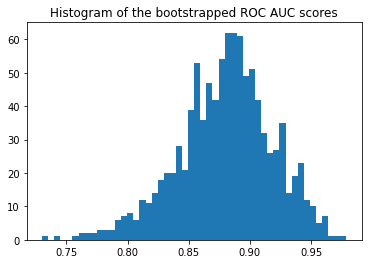

Confidence interval for the score: [0.81 - 0.94]
Original ROC area: 1.00
Bootstrap #1 ROC area: 0.99
Bootstrap #2 ROC area: 1.00
Bootstrap #3 ROC area: 1.00
Bootstrap #4 ROC area: 1.00
Bootstrap #5 ROC area: 1.00
Bootstrap #6 ROC area: 1.00
Bootstrap #7 ROC area: 0.99
Bootstrap #8 ROC area: 1.00
Bootstrap #9 ROC area: 1.00
Bootstrap #10 ROC area: 1.00
Bootstrap #11 ROC area: 0.99
Bootstrap #12 ROC area: 1.00
Bootstrap #13 ROC area: 1.00
Bootstrap #14 ROC area: 1.00
Bootstrap #15 ROC area: 1.00
Bootstrap #16 ROC area: 1.00
Bootstrap #17 ROC area: 1.00
Bootstrap #18 ROC area: 1.00
Bootstrap #19 ROC area: 0.99
Bootstrap #20 ROC area: 1.00
Bootstrap #21 ROC area: 1.00
Bootstrap #22 ROC area: 1.00
Bootstrap #23 ROC area: 0.99
Bootstrap #24 ROC area: 1.00
Bootstrap #25 ROC area: 0.99
Bootstrap #26 ROC area: 1.00
Bootstrap #27 ROC area: 1.00
Bootstrap #28 ROC area: 1.00
Bootstrap #29 ROC area: 1.00
Bootstrap #30 ROC area: 1.00
Bootstrap #31 ROC area: 1.00
Bootstrap #32 ROC area: 1.00
Bootstra

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: Deprecati

Bootstrap #89 ROC area: 1.00
Bootstrap #90 ROC area: 0.99
Bootstrap #91 ROC area: 0.99
Bootstrap #92 ROC area: 0.99
Bootstrap #93 ROC area: 1.00
Bootstrap #94 ROC area: 1.00
Bootstrap #95 ROC area: 1.00
Bootstrap #96 ROC area: 0.99
Bootstrap #97 ROC area: 1.00
Bootstrap #98 ROC area: 1.00
Bootstrap #99 ROC area: 0.99
Bootstrap #100 ROC area: 1.00
Bootstrap #101 ROC area: 0.99
Bootstrap #102 ROC area: 0.99
Bootstrap #103 ROC area: 1.00
Bootstrap #104 ROC area: 0.99
Bootstrap #105 ROC area: 1.00
Bootstrap #106 ROC area: 1.00
Bootstrap #107 ROC area: 0.99
Bootstrap #108 ROC area: 1.00
Bootstrap #109 ROC area: 0.99
Bootstrap #110 ROC area: 0.99
Bootstrap #111 ROC area: 1.00
Bootstrap #112 ROC area: 0.99
Bootstrap #113 ROC area: 1.00
Bootstrap #114 ROC area: 1.00
Bootstrap #115 ROC area: 0.99
Bootstrap #116 ROC area: 0.99
Bootstrap #117 ROC area: 1.00
Bootstrap #118 ROC area: 0.99
Bootstrap #119 ROC area: 1.00
Bootstrap #120 ROC area: 1.00
Bootstrap #121 ROC area: 0.99
Bootstrap #122 ROC ar

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: Deprecati


Bootstrap #198 ROC area: 1.00
Bootstrap #199 ROC area: 0.99
Bootstrap #200 ROC area: 0.99
Bootstrap #201 ROC area: 1.00
Bootstrap #202 ROC area: 0.99
Bootstrap #203 ROC area: 1.00
Bootstrap #204 ROC area: 0.99
Bootstrap #205 ROC area: 1.00
Bootstrap #206 ROC area: 1.00
Bootstrap #207 ROC area: 0.99
Bootstrap #208 ROC area: 0.99
Bootstrap #209 ROC area: 0.99
Bootstrap #210 ROC area: 1.00
Bootstrap #211 ROC area: 1.00
Bootstrap #212 ROC area: 1.00
Bootstrap #213 ROC area: 1.00
Bootstrap #214 ROC area: 1.00
Bootstrap #215 ROC area: 1.00
Bootstrap #216 ROC area: 1.00
Bootstrap #217 ROC area: 1.00
Bootstrap #218 ROC area: 1.00
Bootstrap #219 ROC area: 1.00
Bootstrap #220 ROC area: 1.00
Bootstrap #221 ROC area: 1.00
Bootstrap #222 ROC area: 1.00
Bootstrap #223 ROC area: 1.00
Bootstrap #224 ROC area: 0.99
Bootstrap #225 ROC area: 1.00
Bootstrap #226 ROC area: 1.00
Bootstrap #227 ROC area: 0.99
Bootstrap #228 ROC area: 0.99
Bootstrap #229 ROC area: 0.99
Bootstrap #230 ROC area: 1.00
Bootstrap

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: Deprecati

Bootstrap #310 ROC area: 0.99
Bootstrap #311 ROC area: 1.00
Bootstrap #312 ROC area: 1.00
Bootstrap #313 ROC area: 1.00
Bootstrap #314 ROC area: 1.00
Bootstrap #315 ROC area: 1.00
Bootstrap #316 ROC area: 1.00
Bootstrap #317 ROC area: 1.00
Bootstrap #318 ROC area: 1.00
Bootstrap #319 ROC area: 1.00
Bootstrap #320 ROC area: 1.00
Bootstrap #321 ROC area: 1.00
Bootstrap #322 ROC area: 1.00
Bootstrap #323 ROC area: 1.00
Bootstrap #324 ROC area: 0.99
Bootstrap #325 ROC area: 1.00
Bootstrap #326 ROC area: 1.00
Bootstrap #327 ROC area: 1.00
Bootstrap #328 ROC area: 1.00
Bootstrap #329 ROC area: 1.00
Bootstrap #330 ROC area: 1.00
Bootstrap #331 ROC area: 1.00
Bootstrap #332 ROC area: 1.00
Bootstrap #333 ROC area: 1.00
Bootstrap #334 ROC area: 0.99
Bootstrap #335 ROC area: 1.00
Bootstrap #336 ROC area: 1.00
Bootstrap #337 ROC area: 0.99
Bootstrap #338 ROC area: 1.00
Bootstrap #339 ROC area: 1.00
Bootstrap #340 ROC area: 0.99
Bootstrap #341 ROC area: 0.99
Bootstrap #342 ROC area: 1.00
Bootstrap 

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: Deprecati

Bootstrap #437 ROC area: 1.00
Bootstrap #438 ROC area: 1.00
Bootstrap #439 ROC area: 0.99
Bootstrap #440 ROC area: 1.00
Bootstrap #441 ROC area: 1.00
Bootstrap #442 ROC area: 1.00
Bootstrap #443 ROC area: 0.99
Bootstrap #444 ROC area: 1.00
Bootstrap #445 ROC area: 1.00
Bootstrap #446 ROC area: 0.99
Bootstrap #447 ROC area: 1.00
Bootstrap #448 ROC area: 1.00
Bootstrap #449 ROC area: 1.00
Bootstrap #450 ROC area: 1.00
Bootstrap #451 ROC area: 0.99
Bootstrap #452 ROC area: 1.00
Bootstrap #453 ROC area: 1.00
Bootstrap #454 ROC area: 1.00
Bootstrap #455 ROC area: 1.00
Bootstrap #456 ROC area: 1.00
Bootstrap #457 ROC area: 0.99
Bootstrap #458 ROC area: 1.00
Bootstrap #459 ROC area: 1.00
Bootstrap #460 ROC area: 0.99
Bootstrap #461 ROC area: 1.00
Bootstrap #462 ROC area: 1.00
Bootstrap #463 ROC area: 1.00
Bootstrap #464 ROC area: 1.00
Bootstrap #465 ROC area: 0.99
Bootstrap #466 ROC area: 0.99
Bootstrap #467 ROC area: 1.00
Bootstrap #468 ROC area: 1.00
Bootstrap #469 ROC area: 0.99
Bootstrap 

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: Deprecati


Bootstrap #573 ROC area: 1.00
Bootstrap #574 ROC area: 0.99
Bootstrap #575 ROC area: 0.99
Bootstrap #576 ROC area: 1.00
Bootstrap #577 ROC area: 1.00
Bootstrap #578 ROC area: 1.00
Bootstrap #579 ROC area: 0.99
Bootstrap #580 ROC area: 1.00
Bootstrap #581 ROC area: 0.99
Bootstrap #582 ROC area: 1.00
Bootstrap #583 ROC area: 1.00
Bootstrap #584 ROC area: 1.00
Bootstrap #585 ROC area: 1.00
Bootstrap #586 ROC area: 1.00
Bootstrap #587 ROC area: 1.00
Bootstrap #588 ROC area: 0.99
Bootstrap #589 ROC area: 0.99
Bootstrap #590 ROC area: 0.99
Bootstrap #591 ROC area: 0.99
Bootstrap #592 ROC area: 1.00
Bootstrap #593 ROC area: 1.00
Bootstrap #594 ROC area: 1.00
Bootstrap #595 ROC area: 1.00
Bootstrap #596 ROC area: 1.00
Bootstrap #597 ROC area: 1.00
Bootstrap #598 ROC area: 1.00
Bootstrap #599 ROC area: 0.99
Bootstrap #600 ROC area: 1.00
Bootstrap #601 ROC area: 1.00
Bootstrap #602 ROC area: 0.99
Bootstrap #603 ROC area: 1.00
Bootstrap #604 ROC area: 1.00
Bootstrap #605 ROC area: 0.99
Bootstrap

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: Deprecati

Bootstrap #711 ROC area: 1.00
Bootstrap #712 ROC area: 1.00
Bootstrap #713 ROC area: 1.00
Bootstrap #714 ROC area: 0.99
Bootstrap #715 ROC area: 1.00
Bootstrap #716 ROC area: 1.00
Bootstrap #717 ROC area: 1.00
Bootstrap #718 ROC area: 1.00
Bootstrap #719 ROC area: 0.99
Bootstrap #720 ROC area: 0.99
Bootstrap #721 ROC area: 1.00
Bootstrap #722 ROC area: 1.00
Bootstrap #723 ROC area: 1.00
Bootstrap #724 ROC area: 1.00
Bootstrap #725 ROC area: 0.99
Bootstrap #726 ROC area: 1.00
Bootstrap #727 ROC area: 1.00
Bootstrap #728 ROC area: 1.00
Bootstrap #729 ROC area: 0.99
Bootstrap #730 ROC area: 0.99
Bootstrap #731 ROC area: 0.99
Bootstrap #732 ROC area: 1.00
Bootstrap #733 ROC area: 1.00
Bootstrap #734 ROC area: 1.00
Bootstrap #735 ROC area: 1.00
Bootstrap #736 ROC area: 0.99
Bootstrap #737 ROC area: 1.00
Bootstrap #738 ROC area: 0.99
Bootstrap #739 ROC area: 0.99
Bootstrap #740 ROC area: 1.00
Bootstrap #741 ROC area: 1.00
Bootstrap #742 ROC area: 1.00
Bootstrap #743 ROC area: 1.00
Bootstrap 

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: Deprecati

Bootstrap #851 ROC area: 1.00
Bootstrap #852 ROC area: 1.00
Bootstrap #853 ROC area: 0.99
Bootstrap #854 ROC area: 0.99
Bootstrap #855 ROC area: 0.99
Bootstrap #856 ROC area: 0.99
Bootstrap #857 ROC area: 1.00
Bootstrap #858 ROC area: 1.00
Bootstrap #859 ROC area: 0.99
Bootstrap #860 ROC area: 0.99
Bootstrap #861 ROC area: 0.99
Bootstrap #862 ROC area: 0.99
Bootstrap #863 ROC area: 1.00
Bootstrap #864 ROC area: 0.99
Bootstrap #865 ROC area: 1.00
Bootstrap #866 ROC area: 1.00
Bootstrap #867 ROC area: 1.00
Bootstrap #868 ROC area: 1.00
Bootstrap #869 ROC area: 0.99
Bootstrap #870 ROC area: 1.00
Bootstrap #871 ROC area: 1.00
Bootstrap #872 ROC area: 0.99
Bootstrap #873 ROC area: 1.00
Bootstrap #874 ROC area: 1.00
Bootstrap #875 ROC area: 1.00
Bootstrap #876 ROC area: 1.00
Bootstrap #877 ROC area: 1.00
Bootstrap #878 ROC area: 0.99
Bootstrap #879 ROC area: 0.99
Bootstrap #880 ROC area: 0.99
Bootstrap #881 ROC area: 0.99
Bootstrap #882 ROC area: 1.00
Bootstrap #883 ROC area: 1.00
Bootstrap 

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: Deprecati


Bootstrap #950 ROC area: 1.00
Bootstrap #951 ROC area: 1.00
Bootstrap #952 ROC area: 1.00
Bootstrap #953 ROC area: 1.00
Bootstrap #954 ROC area: 1.00
Bootstrap #955 ROC area: 1.00
Bootstrap #956 ROC area: 0.99
Bootstrap #957 ROC area: 1.00
Bootstrap #958 ROC area: 1.00
Bootstrap #959 ROC area: 1.00
Bootstrap #960 ROC area: 1.00
Bootstrap #961 ROC area: 1.00
Bootstrap #962 ROC area: 0.99
Bootstrap #963 ROC area: 1.00
Bootstrap #964 ROC area: 1.00
Bootstrap #965 ROC area: 0.99
Bootstrap #966 ROC area: 0.99
Bootstrap #967 ROC area: 0.99
Bootstrap #968 ROC area: 0.99
Bootstrap #969 ROC area: 1.00
Bootstrap #970 ROC area: 0.99
Bootstrap #971 ROC area: 1.00
Bootstrap #972 ROC area: 1.00
Bootstrap #973 ROC area: 1.00
Bootstrap #974 ROC area: 1.00
Bootstrap #975 ROC area: 1.00
Bootstrap #976 ROC area: 1.00
Bootstrap #977 ROC area: 1.00
Bootstrap #978 ROC area: 1.00
Bootstrap #979 ROC area: 1.00
Bootstrap #980 ROC area: 1.00
Bootstrap #981 ROC area: 1.00
Bootstrap #982 ROC area: 0.99
Bootstrap

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1195 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: Deprecati

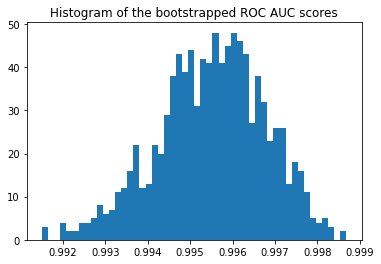

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar

Confidence interval for the score: [0.99 - 1.0]
Original ROC area: 0.83
Bootstrap #1 ROC area: 0.83
Bootstrap #2 ROC area: 0.81
Bootstrap #3 ROC area: 0.88
Bootstrap #4 ROC area: 0.83
Bootstrap #5 ROC area: 0.85
Bootstrap #6 ROC area: 0.80
Bootstrap #7 ROC area: 0.83
Bootstrap #8 ROC area: 0.78
Bootstrap #9 ROC area: 0.86
Bootstrap #10 ROC area: 0.80
Bootstrap #11 ROC area: 0.84
Bootstrap #12 ROC area: 0.81
Bootstrap #13 ROC area: 0.85
Bootstrap #14 ROC area: 0.81
Bootstrap #15 ROC area: 0.85
Bootstrap #16 ROC area: 0.85
Bootstrap #17 ROC area: 0.80
Bootstrap #18 ROC area: 0.80
Bootstrap #19 ROC area: 0.84
Bootstrap #20 ROC area: 0.86
Bootstrap #21 ROC area: 0.82
Bootstrap #22 ROC area: 0.80
Bootstrap #23 ROC area: 0.83
Bootstrap #24 ROC area: 0.84
Bootstrap #25 ROC area: 0.86
Bootstrap #26 ROC area: 0.82
Bootstrap #27 ROC area: 0.82
Bootstrap #28 ROC area: 0.82
Bootstrap #29 ROC area: 0.89
Bootstrap #30 ROC area: 0.82
Bootstrap #31 ROC area: 0.84
Bootstrap #32 ROC area: 0.78
Bootstrap

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar

Bootstrap #206 ROC area: 0.84
Bootstrap #207 ROC area: 0.87
Bootstrap #208 ROC area: 0.84
Bootstrap #209 ROC area: 0.82
Bootstrap #210 ROC area: 0.84
Bootstrap #211 ROC area: 0.83
Bootstrap #212 ROC area: 0.83
Bootstrap #213 ROC area: 0.86
Bootstrap #214 ROC area: 0.81
Bootstrap #215 ROC area: 0.81
Bootstrap #216 ROC area: 0.81
Bootstrap #217 ROC area: 0.83
Bootstrap #218 ROC area: 0.87
Bootstrap #219 ROC area: 0.86
Bootstrap #220 ROC area: 0.82
Bootstrap #221 ROC area: 0.80
Bootstrap #222 ROC area: 0.83
Bootstrap #223 ROC area: 0.80
Bootstrap #224 ROC area: 0.86
Bootstrap #225 ROC area: 0.80
Bootstrap #226 ROC area: 0.87
Bootstrap #227 ROC area: 0.81
Bootstrap #228 ROC area: 0.88
Bootstrap #229 ROC area: 0.83
Bootstrap #230 ROC area: 0.78
Bootstrap #231 ROC area: 0.90
Bootstrap #232 ROC area: 0.85
Bootstrap #233 ROC area: 0.82
Bootstrap #234 ROC area: 0.82
Bootstrap #235 ROC area: 0.82
Bootstrap #236 ROC area: 0.85
Bootstrap #237 ROC area: 0.81
Bootstrap #238 ROC area: 0.87
Bootstrap 

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar

Bootstrap #343 ROC area: 0.82
Bootstrap #344 ROC area: 0.81
Bootstrap #345 ROC area: 0.83
Bootstrap #346 ROC area: 0.85
Bootstrap #347 ROC area: 0.85
Bootstrap #348 ROC area: 0.89
Bootstrap #349 ROC area: 0.83
Bootstrap #350 ROC area: 0.83
Bootstrap #351 ROC area: 0.84
Bootstrap #352 ROC area: 0.85
Bootstrap #353 ROC area: 0.85
Bootstrap #354 ROC area: 0.80
Bootstrap #355 ROC area: 0.86
Bootstrap #356 ROC area: 0.81
Bootstrap #357 ROC area: 0.76
Bootstrap #358 ROC area: 0.89
Bootstrap #359 ROC area: 0.81
Bootstrap #360 ROC area: 0.82
Bootstrap #361 ROC area: 0.85
Bootstrap #362 ROC area: 0.84
Bootstrap #363 ROC area: 0.88
Bootstrap #364 ROC area: 0.84
Bootstrap #365 ROC area: 0.86
Bootstrap #366 ROC area: 0.81
Bootstrap #367 ROC area: 0.84
Bootstrap #368 ROC area: 0.79
Bootstrap #369 ROC area: 0.83
Bootstrap #370 ROC area: 0.82
Bootstrap #371 ROC area: 0.86
Bootstrap #372 ROC area: 0.79
Bootstrap #373 ROC area: 0.88
Bootstrap #374 ROC area: 0.83
Bootstrap #375 ROC area: 0.78
Bootstrap 

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar

Bootstrap #461 ROC area: 0.87
Bootstrap #462 ROC area: 0.87
Bootstrap #463 ROC area: 0.85
Bootstrap #464 ROC area: 0.85
Bootstrap #465 ROC area: 0.84
Bootstrap #466 ROC area: 0.91
Bootstrap #467 ROC area: 0.87
Bootstrap #468 ROC area: 0.83
Bootstrap #469 ROC area: 0.84
Bootstrap #470 ROC area: 0.82
Bootstrap #471 ROC area: 0.88
Bootstrap #472 ROC area: 0.83
Bootstrap #473 ROC area: 0.80
Bootstrap #474 ROC area: 0.83
Bootstrap #475 ROC area: 0.80
Bootstrap #476 ROC area: 0.85
Bootstrap #477 ROC area: 0.82
Bootstrap #478 ROC area: 0.87
Bootstrap #479 ROC area: 0.79
Bootstrap #480 ROC area: 0.82
Bootstrap #481 ROC area: 0.86
Bootstrap #482 ROC area: 0.84
Bootstrap #483 ROC area: 0.87
Bootstrap #484 ROC area: 0.83
Bootstrap #485 ROC area: 0.86
Bootstrap #486 ROC area: 0.82
Bootstrap #487 ROC area: 0.86
Bootstrap #488 ROC area: 0.86
Bootstrap #489 ROC area: 0.83
Bootstrap #490 ROC area: 0.85
Bootstrap #491 ROC area: 0.82
Bootstrap #492 ROC area: 0.79
Bootstrap #493 ROC area: 0.90
Bootstrap 

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar

Bootstrap #608 ROC area: 0.85
Bootstrap #609 ROC area: 0.83
Bootstrap #610 ROC area: 0.84
Bootstrap #611 ROC area: 0.88
Bootstrap #612 ROC area: 0.83
Bootstrap #613 ROC area: 0.83
Bootstrap #614 ROC area: 0.83
Bootstrap #615 ROC area: 0.84
Bootstrap #616 ROC area: 0.84
Bootstrap #617 ROC area: 0.81
Bootstrap #618 ROC area: 0.84
Bootstrap #619 ROC area: 0.82
Bootstrap #620 ROC area: 0.84
Bootstrap #621 ROC area: 0.83
Bootstrap #622 ROC area: 0.87
Bootstrap #623 ROC area: 0.89
Bootstrap #624 ROC area: 0.83
Bootstrap #625 ROC area: 0.83
Bootstrap #626 ROC area: 0.82
Bootstrap #627 ROC area: 0.80
Bootstrap #628 ROC area: 0.87
Bootstrap #629 ROC area: 0.82
Bootstrap #630 ROC area: 0.77
Bootstrap #631 ROC area: 0.83
Bootstrap #632 ROC area: 0.76
Bootstrap #633 ROC area: 0.80
Bootstrap #634 ROC area: 0.90
Bootstrap #635 ROC area: 0.82
Bootstrap #636 ROC area: 0.81
Bootstrap #637 ROC area: 0.78
Bootstrap #638 ROC area: 0.85
Bootstrap #639 ROC area: 0.83
Bootstrap #640 ROC area: 0.90
Bootstrap 

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar


Bootstrap #767 ROC area: 0.89
Bootstrap #768 ROC area: 0.85
Bootstrap #769 ROC area: 0.87
Bootstrap #770 ROC area: 0.77
Bootstrap #771 ROC area: 0.86
Bootstrap #772 ROC area: 0.81
Bootstrap #773 ROC area: 0.83
Bootstrap #774 ROC area: 0.88
Bootstrap #775 ROC area: 0.77
Bootstrap #776 ROC area: 0.81
Bootstrap #777 ROC area: 0.88
Bootstrap #778 ROC area: 0.82
Bootstrap #779 ROC area: 0.81
Bootstrap #780 ROC area: 0.79
Bootstrap #781 ROC area: 0.82
Bootstrap #782 ROC area: 0.85
Bootstrap #783 ROC area: 0.84
Bootstrap #784 ROC area: 0.82
Bootstrap #785 ROC area: 0.81
Bootstrap #786 ROC area: 0.85
Bootstrap #787 ROC area: 0.83
Bootstrap #788 ROC area: 0.85
Bootstrap #789 ROC area: 0.82
Bootstrap #790 ROC area: 0.80
Bootstrap #791 ROC area: 0.84
Bootstrap #792 ROC area: 0.87
Bootstrap #793 ROC area: 0.85
Bootstrap #794 ROC area: 0.83
Bootstrap #795 ROC area: 0.88
Bootstrap #796 ROC area: 0.81
Bootstrap #797 ROC area: 0.80
Bootstrap #798 ROC area: 0.77
Bootstrap #799 ROC area: 0.87
Bootstrap

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar


Bootstrap #928 ROC area: 0.83
Bootstrap #929 ROC area: 0.81
Bootstrap #930 ROC area: 0.84
Bootstrap #931 ROC area: 0.85
Bootstrap #932 ROC area: 0.88
Bootstrap #933 ROC area: 0.84
Bootstrap #934 ROC area: 0.82
Bootstrap #935 ROC area: 0.83
Bootstrap #936 ROC area: 0.79
Bootstrap #937 ROC area: 0.82
Bootstrap #938 ROC area: 0.84
Bootstrap #939 ROC area: 0.77
Bootstrap #940 ROC area: 0.80
Bootstrap #941 ROC area: 0.79
Bootstrap #942 ROC area: 0.84
Bootstrap #943 ROC area: 0.86
Bootstrap #944 ROC area: 0.80
Bootstrap #945 ROC area: 0.81
Bootstrap #946 ROC area: 0.83
Bootstrap #947 ROC area: 0.83
Bootstrap #948 ROC area: 0.83
Bootstrap #949 ROC area: 0.85
Bootstrap #950 ROC area: 0.86
Bootstrap #951 ROC area: 0.85
Bootstrap #952 ROC area: 0.89
Bootstrap #953 ROC area: 0.87
Bootstrap #954 ROC area: 0.86
Bootstrap #955 ROC area: 0.85
Bootstrap #956 ROC area: 0.88
Bootstrap #957 ROC area: 0.79
Bootstrap #958 ROC area: 0.83
Bootstrap #959 ROC area: 0.88
Bootstrap #960 ROC area: 0.86
Bootstrap

<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 650 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-15-1393675ce4ff>:17: DeprecationWar

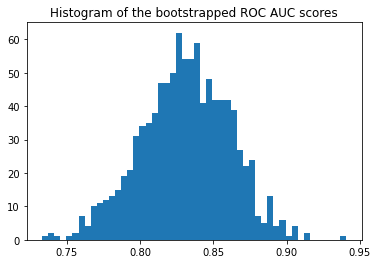

Confidence interval for the score: [0.78 - 0.88]
Wall time: 16.3 s


In [20]:
%%time
test_auc_list = []; train_auc_list = []; train_auc_CV_list = []; validation_auc_list = []
test_auc_liebiao = []; train_auc_liebiao = []; train_auc_CV_liebiao = []; validation_auc_liebiao = [] 
feature_importance_list = []
index_train_list = []; index_test_list = []; index_validation_list = []
index_train_liebiao = []; index_test_liebiao = []; index_validation_liebiao = []

for i in range(len(type_name)):
    #############################第一次建模
    ####### 准备数据
    train_pos = data_train[data_train['type'] == type_name[i]]
    train_neg = data_train[data_train['type'] != type_name[i]]; train_neg = train_neg[train_neg['type'] != 'n.a.']
    test_pos = data_test[data_test['type'] == type_name[i]]
    test_neg = data_test[data_test['type'] != type_name[i]]; test_neg = test_neg[test_neg['type'] != 'n.a.']
    validation_pos = data_validation[data_validation['type'] == type_name[i]]
    validation_neg = data_validation[data_validation['type'] != type_name[i]]; validation_neg = validation_neg[validation_neg['type'] != 'n.a.']

    train_pos['outcome'] = [1 for i in range(train_pos.shape[0])]
    train_neg['outcome'] = [0 for i in range(train_neg.shape[0])]
    test_pos['outcome'] = [1 for i in range(test_pos.shape[0])]
    test_neg['outcome'] = [0 for i in range(test_neg.shape[0])]
    validation_pos['outcome'] = [1 for i in range(validation_pos.shape[0])]
    validation_neg['outcome'] = [0 for i in range(validation_neg.shape[0])]

    trainset = pd.concat([train_pos, train_neg], axis=0) # 拼接
    testset = pd.concat([test_pos, test_neg], axis=0) # 拼接
    X_train = trainset[feature_total]
    X_test = testset[feature_total]
    y_train = trainset['outcome']
    y_test = testset['outcome']
    validationset = pd.concat([validation_pos, validation_neg], axis=0) # 拼接
    X_validation = validationset[feature_total]
    y_validation = validationset['outcome']

    # 随机数
    seed = 123

    ####### 过采样
    over_sample = SMOTE(sampling_strategy='minority', random_state=seed, k_neighbors=4)
    X_train, y_train = over_sample.fit_resample(X_train, y_train)
    X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=seed) # 打乱
    # 不再标准化
    # 保存标准化+过采样的全特征数据集
    X_df_train = pd.DataFrame(X_train, columns=feature_total)
    X_df_test = pd.DataFrame(X_test, columns=feature_total)
    X_df_validation = pd.DataFrame(X_validation, columns=feature_total)

    ####### 方差筛选
    selector = VarianceThreshold(threshold=2.1)
    selector.fit_transform(X_train, y_train)
    feature_VarianceThreshold = selector.get_feature_names_out(input_features=feature_total)
    feature_VarianceThreshold.tolist()
    print(len(feature_VarianceThreshold))

    X_train = np.array(X_df_train[feature_VarianceThreshold])
    X_test = np.array(X_df_test[feature_VarianceThreshold])
    X_validation = np.array(X_df_validation[feature_VarianceThreshold])

    # 待用数据集转为np
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    X_validation = np.array(X_validation)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_validation = np.array(y_validation)
    

    ######## XGB建模
    model_XGB = XGBClassifier(n_estimators=70, max_depth=1, subsample=0.9, 
                          colsample_bytree=1, reg_alpha= 0.1, 
                          objective= 'binary:logistic', nthread=8,
                        scale_pos_weight=1, seed=123)
    model_XGB.fit(X_train, y_train)  

    test_auc_XGB = metrics.roc_auc_score(y_test, model_XGB.predict_proba(X_test)[:,1])
    train_auc_XGB = metrics.roc_auc_score(y_train, model_XGB.predict_proba(X_train)[:,1])
    validation_auc_XGB = metrics.roc_auc_score(y_validation, model_XGB.predict_proba(X_validation)[:,1])
    train_auc_XGB_CV = cross_val_score(model_XGB, X_train, y_train, cv=10, scoring='roc_auc')
    train_auc_XGB_CV = train_auc_XGB_CV.mean()
    
    test_auc_list.append(test_auc_XGB); train_auc_list.append(train_auc_XGB)
    train_auc_CV_list.append(train_auc_XGB_CV); validation_auc_list.append(validation_auc_XGB)

    ####### 重要性
    X_columns = feature_VarianceThreshold
    importance_XGB = model_XGB.feature_importances_
    imp_result = np.argsort(importance_XGB)[::-1][:]
    for j in range(len(imp_result)):
        print("%2d. %-*s %f" % (j + 1, 30, X_columns[imp_result[j]], importance_XGB[imp_result[j]]))
    X_columns_XGB = [X_columns[j] for j in imp_result]
    col_name = []
    imp_num = []
    for j in range(len(imp_result)):
        col_name.append(X_columns[imp_result[j]])
        imp_num.append(importance_XGB[imp_result[j]])
    col_name = np.array(col_name)
    col_name = col_name[:,np.newaxis]
    imp_num = np.array(imp_num)
    imp_num = imp_num[:,np.newaxis]
    feature_importance_XGB = np.hstack([col_name, imp_num])
    if i == 0:
        feature_importance_np = feature_importance_XGB[:100,:]
    else:
        feature_importance_np = np.hstack([feature_importance_np, feature_importance_XGB[:100,:]])
    
    feature_importance_list.append(feature_importance_XGB)
    
    '''
    ###### 置信区间
    confidence_interval_test_XGB = Confidence_Interval(model_XGB.predict_proba(X_test)[:,1], y_test)
    confidence_interval_train_XGB = Confidence_Interval(model_XGB.predict_proba(X_train)[:,1], y_train)

    ###### 其他指标
    f1_test_XGB, f2_test_XGB, f05_test_XGB, precision_test_XGB, recall_test_XGB, PPV_test_XGB, NPV_test_XGB, FAR_test_XGB, accuracy_test_XGB, specificity_test_XGB = sk_matrix(model_XGB, y_test, model_XGB.predict(X_test))
    f1_train_XGB, f2_train_XGB, f05_train_XGB, precision_train_XGB, recall_train_XGB, PPV_train_XGB, NPV_train_XGB, FAR_train_XGB, accuracy_train_XGB, specificity_train_XGB = sk_matrix(model_XGB, y_train, model_XGB.predict(X_train))
    index_test = [f1_test_XGB, f2_test_XGB, f05_test_XGB, precision_test_XGB, recall_test_XGB, PPV_test_XGB, NPV_test_XGB, FAR_test_XGB, accuracy_test_XGB, specificity_test_XGB]
    index_train = [f1_train_XGB, f2_train_XGB, f05_train_XGB, precision_train_XGB, recall_train_XGB, PPV_train_XGB, NPV_train_XGB, FAR_train_XGB, accuracy_train_XGB, specificity_train_XGB]
    
    index_test_list.append(index_test); index_train_list.append(index_train)
    '''
    #############################第二次建模
    ####### 准备数据
    n_feature = 25
    X_train = np.array(X_df_train[feature_importance_XGB[:n_feature, 0]])
    X_test = np.array(X_df_test[feature_importance_XGB[:n_feature, 0]])
    X_validation = np.array(X_df_validation[feature_importance_XGB[:n_feature, 0]])

    # 待用数据集转为np
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    X_validation = np.array(X_validation)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_validation = np.array(y_validation)

    ####### 第二次XGB建模
    model_XGB = XGBClassifier(n_estimators=40, max_depth=1, subsample=0.9, 
                          colsample_bytree=1, reg_alpha= 0.1, 
                          objective= 'binary:logistic', nthread=8,
                        scale_pos_weight=1, seed=123)
    model_XGB.fit(X_train, y_train)  

    test_auc_XGB = metrics.roc_auc_score(y_test, model_XGB.predict_proba(X_test)[:,1])
    train_auc_XGB = metrics.roc_auc_score(y_train, model_XGB.predict_proba(X_train)[:,1])
    validation_auc_XGB = metrics.roc_auc_score(y_validation, model_XGB.predict_proba(X_validation)[:,1])
    train_auc_XGB_CV = cross_val_score(model_XGB, X_train, y_train, cv=10, scoring='roc_auc')
    train_auc_XGB_CV = train_auc_XGB_CV.mean()
    
    ###### 置信区间
    confidence_interval_test_XGB = Confidence_Interval(model_XGB.predict_proba(X_test)[:,1], y_test)
    confidence_interval_train_XGB = Confidence_Interval(model_XGB.predict_proba(X_train)[:,1], y_train)
    confidence_interval_validation_XGB = Confidence_Interval(model_XGB.predict_proba(X_validation)[:,1], y_validation)
    
    train_auc_XGB = str(round(train_auc_XGB, 2)) + ' ' + confidence_interval_train_XGB
    test_auc_XGB = str(round(test_auc_XGB, 2)) + ' ' + confidence_interval_test_XGB
    validation_auc_XGB = str(round(validation_auc_XGB, 2)) + ' ' + confidence_interval_validation_XGB
    
    test_auc_liebiao.append(test_auc_XGB); train_auc_liebiao.append(train_auc_XGB)
    train_auc_CV_liebiao.append(train_auc_XGB_CV); validation_auc_liebiao.append(validation_auc_XGB)

    '''
    ###### 其他指标
    f1_test_XGB, f2_test_XGB, f05_test_XGB, precision_test_XGB, recall_test_XGB, PPV_test_XGB, NPV_test_XGB, FAR_test_XGB, accuracy_test_XGB, specificity_test_XGB = sk_matrix(model_XGB, y_test, model_XGB.predict(X_test))
    f1_train_XGB, f2_train_XGB, f05_train_XGB, precision_train_XGB, recall_train_XGB, PPV_train_XGB, NPV_train_XGB, FAR_train_XGB, accuracy_train_XGB, specificity_train_XGB = sk_matrix(model_XGB, y_train, model_XGB.predict(X_train))
    index_test = [f1_test_XGB, f2_test_XGB, f05_test_XGB, precision_test_XGB, recall_test_XGB, PPV_test_XGB, NPV_test_XGB, FAR_test_XGB, accuracy_test_XGB, specificity_test_XGB]
    index_train = [f1_train_XGB, f2_train_XGB, f05_train_XGB, precision_train_XGB, recall_train_XGB, PPV_train_XGB, NPV_train_XGB, FAR_train_XGB, accuracy_train_XGB, specificity_train_XGB]
    f1_validation_XGB, f2_validation_XGB, f05_validation_XGB, precision_validation_XGB, recall_validation_XGB, PPV_validation_XGB, NPV_validation_XGB, FAR_validation_XGB, accuracy_validation_XGB, specificity_validation_XGB = sk_matrix(model_XGB, y_validation, model_XGB.predict(X_validation))    
    index_validation = [f1_validation_XGB, f2_validation_XGB, f05_validation_XGB, precision_validation_XGB, recall_validation_XGB, PPV_validation_XGB, NPV_validation_XGB, FAR_validation_XGB, accuracy_validation_XGB, specificity_validation_XGB]
    
    index_train_liebiao.append(index_test); index_test_liebiao.append(index_train); index_validation_liebiao.append(index_validation)
    '''
    break

In [37]:
feature_importance_np = np.array(feature_importance_np)
feature_importance_np = pd.DataFrame(feature_importance_np, columns=['Glioma', ' ', 'Non-small-cell lung cancer', ' ', 
                                                                     'Pancreatic cancer', ' ', 'Breast cancer', ' ', 'Head and neck cancer', ' ', 
                                                                     'Melanoma', ' ', 'Ovarian cancer', ' ', 'Colorectal cancer', ' ', 
                                                                     'Multiple Myeloma', ' ', 'Sarcoma', ' ', 'Cholangiocarcinoma', ' ', 
                                                                     'Hepatocellular carcinoma', ' ', 'Endometrial cancer', ' ', 
                                                                     'Esophageal carcinoma', ' ', 'Lymphoma', ' ', 'Prostate cancer', ' ', 
                                                                     'Renal cell cancer', ' ', 'Urothelial cancer', ' '])
feature_importance_np.to_csv('feature_type.csv')

In [38]:
index_1000 = np.hstack([np.array(train_auc_list).reshape(-1,1), np.array(train_auc_CV_list).reshape(-1,1), np.array(test_auc_list).reshape(-1,1), np.array(validation_auc_list).reshape(-1,1)])
index_25 = np.hstack([np.array(train_auc_liebiao).reshape(-1,1), np.array(train_auc_CV_liebiao).reshape(-1,1), np.array(test_auc_liebiao).reshape(-1,1), np.array(validation_auc_liebiao).reshape(-1,1)])
index_total = np.hstack([index_1000, index_25])
index_name = np.array(['train_1000', 'train_CV_1000', 'test_1000', 'validation_1000', 'train_25', 'train_CV_25', 'test_25', 'validation_25'])

index_total = np.vstack([index_name, index_total])
index_total = np.hstack([np.array(['type']+type_name).reshape(-1,1), index_total])

index_total = pd.DataFrame(index_total)
index_total.to_csv('过采样_type.csv')

# Add

In [34]:
stage_name = ['I', 'II', 'III', 'IV']
train_pos = data_train[data_train['Stage'] == stage_name[0]]; train_pos2 = data_train[data_train['Stage'] == stage_name[1]]; train_pos = pd.concat([train_pos, train_pos2], axis=0)
train_neg = data_train[data_train['Stage'] != stage_name[0]]; train_neg = train_neg[train_neg['Stage'] != stage_name[1]]

In [35]:
stage_name = ['I', 'II', 'III', 'IV']
test_pos = data_test[data_test['Stage'] == stage_name[0]]; test_pos2 = data_test[data_test['Stage'] == stage_name[1]]; test_pos = pd.concat([test_pos, test_pos2], axis=0)
test_neg = data_test[data_test['Stage'] != stage_name[0]]; test_neg = test_neg[test_neg['Stage'] != stage_name[1]]

In [36]:
stage_name = ['I', 'II', 'III', 'IV']
validation_pos = data_validation[data_validation['Stage'] == stage_name[0]]; validation_pos2 = data_validation[data_validation['Stage'] == stage_name[0]]; validation_pos = pd.concat([validation_pos, validation_pos2], axis=0)
validation_neg = data_validation[data_validation['Stage'] != stage_name[0]]; validation_neg = validation_neg[validation_neg['Stage'] != stage_name[1]]

D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1111
全部特征：
0.9662522646788713 0.9140468822740093 0.6801916032685263 0.7211246555508851
 1. CPNE4                          0.091639
 2. CXCL8                          0.066990
 3. GFM1                           0.055978
 4. ZNF385D                        0.052485
 5. THOC1                          0.046110
 6. ENSG00000269028                0.039521
 7. BTBD11                         0.035945
 8. USP5                           0.032918
 9. ZNF667-AS1                     0.032210
10. ENSG00000260017                0.032200
11. ENSG00000187653                0.028194
12. IARS2                          0.028001
13. FECH                           0.027745
14. HIP1R                      

D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:

[00:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:

[00:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:

[00:28:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files (x86)\Anaconda3.8\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers

[00:28:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Original ROC area: 0.70
Bootstrap #1 ROC area: 0.70
Bootstrap #2 ROC area: 0.78
Bootstrap #3 ROC area: 0.75
Bootstrap #4 ROC area: 0.73
Bootstrap #5 ROC area: 0.69
Bootstrap #6 ROC area: 0.77
Bootstrap #7 ROC area: 0.73
Bootstrap #8 ROC area: 0.75
Bootstrap #9 ROC area: 0.74
Bootstrap #10 ROC area: 0.75
Bootstrap #11 ROC area: 0.71
Bootstrap #12 ROC area: 0.65
Bootstrap #13 ROC area: 0.67
Bootstrap #14 ROC area: 0.74
Bootstrap #15 ROC area: 0.72
Bootstrap #16 ROC area: 0.68
Bootstrap #17 ROC area: 0.70
Bootstrap #18 ROC area: 0.73
Bootstrap #19 ROC area: 0.66
Bootstrap #20 ROC area: 0.75
Bootstrap #21 ROC area: 0.69
Bootstrap #22 ROC area: 0.72
Bootstrap #23 ROC area: 0.74
Bootstra

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar

Bootstrap #43 ROC area: 0.71
Bootstrap #44 ROC area: 0.71
Bootstrap #45 ROC area: 0.67
Bootstrap #46 ROC area: 0.69
Bootstrap #47 ROC area: 0.72
Bootstrap #48 ROC area: 0.69
Bootstrap #49 ROC area: 0.77
Bootstrap #50 ROC area: 0.67
Bootstrap #51 ROC area: 0.73
Bootstrap #52 ROC area: 0.70
Bootstrap #53 ROC area: 0.78
Bootstrap #54 ROC area: 0.66
Bootstrap #55 ROC area: 0.67
Bootstrap #56 ROC area: 0.66
Bootstrap #57 ROC area: 0.69
Bootstrap #58 ROC area: 0.73
Bootstrap #59 ROC area: 0.76
Bootstrap #60 ROC area: 0.68
Bootstrap #61 ROC area: 0.71
Bootstrap #62 ROC area: 0.74
Bootstrap #63 ROC area: 0.60
Bootstrap #64 ROC area: 0.70
Bootstrap #65 ROC area: 0.72
Bootstrap #66 ROC area: 0.68
Bootstrap #67 ROC area: 0.66
Bootstrap #68 ROC area: 0.66
Bootstrap #69 ROC area: 0.67
Bootstrap #70 ROC area: 0.71
Bootstrap #71 ROC area: 0.71
Bootstrap #72 ROC area: 0.66
Bootstrap #73 ROC area: 0.70
Bootstrap #74 ROC area: 0.64
Bootstrap #75 ROC area: 0.69
Bootstrap #76 ROC area: 0.62
Bootstrap #77 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar

Bootstrap #145 ROC area: 0.72
Bootstrap #146 ROC area: 0.68
Bootstrap #147 ROC area: 0.70
Bootstrap #148 ROC area: 0.68
Bootstrap #149 ROC area: 0.78
Bootstrap #150 ROC area: 0.66
Bootstrap #151 ROC area: 0.70
Bootstrap #152 ROC area: 0.71
Bootstrap #153 ROC area: 0.73
Bootstrap #154 ROC area: 0.66
Bootstrap #155 ROC area: 0.69
Bootstrap #156 ROC area: 0.60
Bootstrap #157 ROC area: 0.75
Bootstrap #158 ROC area: 0.78
Bootstrap #159 ROC area: 0.77
Bootstrap #160 ROC area: 0.61
Bootstrap #161 ROC area: 0.70
Bootstrap #162 ROC area: 0.75
Bootstrap #163 ROC area: 0.63
Bootstrap #164 ROC area: 0.72
Bootstrap #165 ROC area: 0.74
Bootstrap #166 ROC area: 0.74
Bootstrap #167 ROC area: 0.69
Bootstrap #168 ROC area: 0.73
Bootstrap #169 ROC area: 0.68
Bootstrap #170 ROC area: 0.66
Bootstrap #171 ROC area: 0.77
Bootstrap #172 ROC area: 0.68
Bootstrap #173 ROC area: 0.68
Bootstrap #174 ROC area: 0.74
Bootstrap #175 ROC area: 0.70
Bootstrap #176 ROC area: 0.64
Bootstrap #177 ROC area: 0.68
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar

Bootstrap #266 ROC area: 0.61
Bootstrap #267 ROC area: 0.66
Bootstrap #268 ROC area: 0.75
Bootstrap #269 ROC area: 0.66
Bootstrap #270 ROC area: 0.71
Bootstrap #271 ROC area: 0.72
Bootstrap #272 ROC area: 0.68
Bootstrap #273 ROC area: 0.68
Bootstrap #274 ROC area: 0.70
Bootstrap #275 ROC area: 0.70
Bootstrap #276 ROC area: 0.71
Bootstrap #277 ROC area: 0.76
Bootstrap #278 ROC area: 0.76
Bootstrap #279 ROC area: 0.75
Bootstrap #280 ROC area: 0.62
Bootstrap #281 ROC area: 0.71
Bootstrap #282 ROC area: 0.68
Bootstrap #283 ROC area: 0.67
Bootstrap #284 ROC area: 0.67
Bootstrap #285 ROC area: 0.66
Bootstrap #286 ROC area: 0.67
Bootstrap #287 ROC area: 0.67
Bootstrap #288 ROC area: 0.71
Bootstrap #289 ROC area: 0.69
Bootstrap #290 ROC area: 0.80
Bootstrap #291 ROC area: 0.69
Bootstrap #292 ROC area: 0.78
Bootstrap #293 ROC area: 0.72
Bootstrap #294 ROC area: 0.73
Bootstrap #295 ROC area: 0.74
Bootstrap #296 ROC area: 0.72
Bootstrap #297 ROC area: 0.64
Bootstrap #298 ROC area: 0.71
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar


Bootstrap #392 ROC area: 0.67
Bootstrap #393 ROC area: 0.68
Bootstrap #394 ROC area: 0.72
Bootstrap #395 ROC area: 0.71
Bootstrap #396 ROC area: 0.76
Bootstrap #397 ROC area: 0.69
Bootstrap #398 ROC area: 0.66
Bootstrap #399 ROC area: 0.74
Bootstrap #400 ROC area: 0.71
Bootstrap #401 ROC area: 0.77
Bootstrap #402 ROC area: 0.75
Bootstrap #403 ROC area: 0.64
Bootstrap #404 ROC area: 0.70
Bootstrap #405 ROC area: 0.75
Bootstrap #406 ROC area: 0.70
Bootstrap #407 ROC area: 0.69
Bootstrap #408 ROC area: 0.73
Bootstrap #409 ROC area: 0.66
Bootstrap #410 ROC area: 0.68
Bootstrap #411 ROC area: 0.68
Bootstrap #412 ROC area: 0.84
Bootstrap #413 ROC area: 0.71
Bootstrap #414 ROC area: 0.73
Bootstrap #415 ROC area: 0.73
Bootstrap #416 ROC area: 0.74
Bootstrap #417 ROC area: 0.74
Bootstrap #418 ROC area: 0.71
Bootstrap #419 ROC area: 0.72
Bootstrap #420 ROC area: 0.72
Bootstrap #421 ROC area: 0.72
Bootstrap #422 ROC area: 0.72
Bootstrap #423 ROC area: 0.66
Bootstrap #424 ROC area: 0.62
Bootstrap

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar

Bootstrap #519 ROC area: 0.65
Bootstrap #520 ROC area: 0.69
Bootstrap #521 ROC area: 0.72
Bootstrap #522 ROC area: 0.70
Bootstrap #523 ROC area: 0.73
Bootstrap #524 ROC area: 0.65
Bootstrap #525 ROC area: 0.68
Bootstrap #526 ROC area: 0.70
Bootstrap #527 ROC area: 0.70
Bootstrap #528 ROC area: 0.74
Bootstrap #529 ROC area: 0.73
Bootstrap #530 ROC area: 0.72
Bootstrap #531 ROC area: 0.70
Bootstrap #532 ROC area: 0.70
Bootstrap #533 ROC area: 0.75
Bootstrap #534 ROC area: 0.66
Bootstrap #535 ROC area: 0.68
Bootstrap #536 ROC area: 0.75
Bootstrap #537 ROC area: 0.71
Bootstrap #538 ROC area: 0.66
Bootstrap #539 ROC area: 0.71
Bootstrap #540 ROC area: 0.69
Bootstrap #541 ROC area: 0.67
Bootstrap #542 ROC area: 0.71
Bootstrap #543 ROC area: 0.72
Bootstrap #544 ROC area: 0.61
Bootstrap #545 ROC area: 0.66
Bootstrap #546 ROC area: 0.66
Bootstrap #547 ROC area: 0.71
Bootstrap #548 ROC area: 0.71
Bootstrap #549 ROC area: 0.71
Bootstrap #550 ROC area: 0.73
Bootstrap #551 ROC area: 0.75
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar

Bootstrap #644 ROC area: 0.70
Bootstrap #645 ROC area: 0.69
Bootstrap #646 ROC area: 0.76
Bootstrap #647 ROC area: 0.76
Bootstrap #648 ROC area: 0.70
Bootstrap #649 ROC area: 0.77
Bootstrap #650 ROC area: 0.73
Bootstrap #651 ROC area: 0.65
Bootstrap #652 ROC area: 0.69
Bootstrap #653 ROC area: 0.70
Bootstrap #654 ROC area: 0.70
Bootstrap #655 ROC area: 0.67
Bootstrap #656 ROC area: 0.72
Bootstrap #657 ROC area: 0.75
Bootstrap #658 ROC area: 0.75
Bootstrap #659 ROC area: 0.66
Bootstrap #660 ROC area: 0.68
Bootstrap #661 ROC area: 0.81
Bootstrap #662 ROC area: 0.73
Bootstrap #663 ROC area: 0.76
Bootstrap #664 ROC area: 0.73
Bootstrap #665 ROC area: 0.73
Bootstrap #666 ROC area: 0.70
Bootstrap #667 ROC area: 0.58
Bootstrap #668 ROC area: 0.77
Bootstrap #669 ROC area: 0.69
Bootstrap #670 ROC area: 0.74
Bootstrap #671 ROC area: 0.76
Bootstrap #672 ROC area: 0.73
Bootstrap #673 ROC area: 0.73
Bootstrap #674 ROC area: 0.70
Bootstrap #675 ROC area: 0.75
Bootstrap #676 ROC area: 0.63
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar


Bootstrap #758 ROC area: 0.69
Bootstrap #759 ROC area: 0.71
Bootstrap #760 ROC area: 0.73
Bootstrap #761 ROC area: 0.69
Bootstrap #762 ROC area: 0.68
Bootstrap #763 ROC area: 0.73
Bootstrap #764 ROC area: 0.74
Bootstrap #765 ROC area: 0.69
Bootstrap #766 ROC area: 0.77
Bootstrap #767 ROC area: 0.68
Bootstrap #768 ROC area: 0.68
Bootstrap #769 ROC area: 0.75
Bootstrap #770 ROC area: 0.74
Bootstrap #771 ROC area: 0.72
Bootstrap #772 ROC area: 0.72
Bootstrap #773 ROC area: 0.68
Bootstrap #774 ROC area: 0.67
Bootstrap #775 ROC area: 0.66
Bootstrap #776 ROC area: 0.66
Bootstrap #777 ROC area: 0.66
Bootstrap #778 ROC area: 0.69
Bootstrap #779 ROC area: 0.73
Bootstrap #780 ROC area: 0.66
Bootstrap #781 ROC area: 0.70
Bootstrap #782 ROC area: 0.68
Bootstrap #783 ROC area: 0.70
Bootstrap #784 ROC area: 0.69
Bootstrap #785 ROC area: 0.75
Bootstrap #786 ROC area: 0.66
Bootstrap #787 ROC area: 0.63
Bootstrap #788 ROC area: 0.71
Bootstrap #789 ROC area: 0.69
Bootstrap #790 ROC area: 0.72
Bootstrap

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar


Bootstrap #875 ROC area: 0.69
Bootstrap #876 ROC area: 0.72
Bootstrap #877 ROC area: 0.66
Bootstrap #878 ROC area: 0.69
Bootstrap #879 ROC area: 0.78
Bootstrap #880 ROC area: 0.68
Bootstrap #881 ROC area: 0.79
Bootstrap #882 ROC area: 0.71
Bootstrap #883 ROC area: 0.62
Bootstrap #884 ROC area: 0.71
Bootstrap #885 ROC area: 0.69
Bootstrap #886 ROC area: 0.60
Bootstrap #887 ROC area: 0.71
Bootstrap #888 ROC area: 0.77
Bootstrap #889 ROC area: 0.60
Bootstrap #890 ROC area: 0.70
Bootstrap #891 ROC area: 0.70
Bootstrap #892 ROC area: 0.70
Bootstrap #893 ROC area: 0.68
Bootstrap #894 ROC area: 0.67
Bootstrap #895 ROC area: 0.64
Bootstrap #896 ROC area: 0.75
Bootstrap #897 ROC area: 0.71
Bootstrap #898 ROC area: 0.72
Bootstrap #899 ROC area: 0.65
Bootstrap #900 ROC area: 0.73
Bootstrap #901 ROC area: 0.70
Bootstrap #902 ROC area: 0.73
Bootstrap #903 ROC area: 0.80
Bootstrap #904 ROC area: 0.72
Bootstrap #905 ROC area: 0.72
Bootstrap #906 ROC area: 0.71
Bootstrap #907 ROC area: 0.73
Bootstrap

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 324 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar

Bootstrap #992 ROC area: 0.72
Bootstrap #993 ROC area: 0.68
Bootstrap #994 ROC area: 0.72
Bootstrap #995 ROC area: 0.73
Bootstrap #996 ROC area: 0.74
Bootstrap #997 ROC area: 0.67
Bootstrap #998 ROC area: 0.71
Bootstrap #999 ROC area: 0.71
Bootstrap #1000 ROC area: 0.70


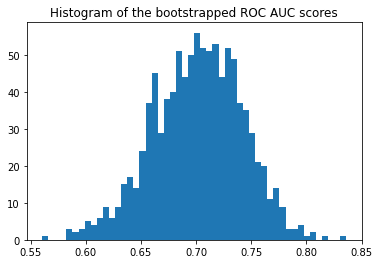

Confidence interval for the score: [0.63 - 0.76]
Original ROC area: 0.95
Bootstrap #1 ROC area: 0.96
Bootstrap #2 ROC area: 0.95
Bootstrap #3 ROC area: 0.95
Bootstrap #4 ROC area: 0.96
Bootstrap #5 ROC area: 0.95
Bootstrap #6 ROC area: 0.95
Bootstrap #7 ROC area: 0.96
Bootstrap #8 ROC area: 0.96
Bootstrap #9 ROC area: 0.95
Bootstrap #10 ROC area: 0.96
Bootstrap #11 ROC area: 0.95
Bootstrap #12 ROC area: 0.95
Bootstrap #13 ROC area: 0.95
Bootstrap #14 ROC area: 0.95
Bootstrap #15 ROC area: 0.95
Bootstrap #16 ROC area: 0.95
Bootstrap #17 ROC area: 0.95
Bootstrap #18 ROC area: 0.95
Bootstrap #19 ROC area: 0.96
Bootstrap #20 ROC area: 0.96
Bootstrap #21 ROC area: 0.96
Bootstrap #22 ROC area: 0.96
Bootstrap #23 ROC area: 0.94
Bootstrap #24 ROC area: 0.95
Bootstrap #25 ROC area: 0.96
Bootstrap #26 ROC area: 0.95
Bootstrap #27 ROC area: 0.96
Bootstrap #28 ROC area: 0.96
Bootstrap #29 ROC area: 0.96
Bootstrap #30 ROC area: 0.95
Bootstrap #31 ROC area: 0.96
Bootstrap #32 ROC area: 0.96
Bootstra

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: Deprecati


Bootstrap #72 ROC area: 0.95
Bootstrap #73 ROC area: 0.95
Bootstrap #74 ROC area: 0.96
Bootstrap #75 ROC area: 0.95
Bootstrap #76 ROC area: 0.95
Bootstrap #77 ROC area: 0.96
Bootstrap #78 ROC area: 0.96
Bootstrap #79 ROC area: 0.97
Bootstrap #80 ROC area: 0.96
Bootstrap #81 ROC area: 0.95
Bootstrap #82 ROC area: 0.95
Bootstrap #83 ROC area: 0.96
Bootstrap #84 ROC area: 0.95
Bootstrap #85 ROC area: 0.96
Bootstrap #86 ROC area: 0.95
Bootstrap #87 ROC area: 0.95
Bootstrap #88 ROC area: 0.96
Bootstrap #89 ROC area: 0.97
Bootstrap #90 ROC area: 0.96
Bootstrap #91 ROC area: 0.96
Bootstrap #92 ROC area: 0.96
Bootstrap #93 ROC area: 0.95
Bootstrap #94 ROC area: 0.95
Bootstrap #95 ROC area: 0.94
Bootstrap #96 ROC area: 0.95
Bootstrap #97 ROC area: 0.96
Bootstrap #98 ROC area: 0.96
Bootstrap #99 ROC area: 0.96
Bootstrap #100 ROC area: 0.96
Bootstrap #101 ROC area: 0.95
Bootstrap #102 ROC area: 0.96
Bootstrap #103 ROC area: 0.96
Bootstrap #104 ROC area: 0.96
Bootstrap #105 ROC area: 0.95
Bootstr

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: Deprecati


Bootstrap #164 ROC area: 0.95
Bootstrap #165 ROC area: 0.96
Bootstrap #166 ROC area: 0.96
Bootstrap #167 ROC area: 0.95
Bootstrap #168 ROC area: 0.97
Bootstrap #169 ROC area: 0.96
Bootstrap #170 ROC area: 0.95
Bootstrap #171 ROC area: 0.96
Bootstrap #172 ROC area: 0.96
Bootstrap #173 ROC area: 0.97
Bootstrap #174 ROC area: 0.96
Bootstrap #175 ROC area: 0.96
Bootstrap #176 ROC area: 0.96
Bootstrap #177 ROC area: 0.96
Bootstrap #178 ROC area: 0.96
Bootstrap #179 ROC area: 0.96
Bootstrap #180 ROC area: 0.95
Bootstrap #181 ROC area: 0.95
Bootstrap #182 ROC area: 0.94
Bootstrap #183 ROC area: 0.95
Bootstrap #184 ROC area: 0.95
Bootstrap #185 ROC area: 0.94
Bootstrap #186 ROC area: 0.95
Bootstrap #187 ROC area: 0.95
Bootstrap #188 ROC area: 0.96
Bootstrap #189 ROC area: 0.96
Bootstrap #190 ROC area: 0.95
Bootstrap #191 ROC area: 0.96
Bootstrap #192 ROC area: 0.95
Bootstrap #193 ROC area: 0.96
Bootstrap #194 ROC area: 0.96
Bootstrap #195 ROC area: 0.96
Bootstrap #196 ROC area: 0.96
Bootstrap

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: Deprecati

Bootstrap #257 ROC area: 0.95
Bootstrap #258 ROC area: 0.96
Bootstrap #259 ROC area: 0.95
Bootstrap #260 ROC area: 0.95
Bootstrap #261 ROC area: 0.96
Bootstrap #262 ROC area: 0.97
Bootstrap #263 ROC area: 0.96
Bootstrap #264 ROC area: 0.95
Bootstrap #265 ROC area: 0.95
Bootstrap #266 ROC area: 0.95
Bootstrap #267 ROC area: 0.95
Bootstrap #268 ROC area: 0.95
Bootstrap #269 ROC area: 0.95
Bootstrap #270 ROC area: 0.97
Bootstrap #271 ROC area: 0.96
Bootstrap #272 ROC area: 0.95
Bootstrap #273 ROC area: 0.95
Bootstrap #274 ROC area: 0.96
Bootstrap #275 ROC area: 0.95
Bootstrap #276 ROC area: 0.96
Bootstrap #277 ROC area: 0.96
Bootstrap #278 ROC area: 0.95
Bootstrap #279 ROC area: 0.96
Bootstrap #280 ROC area: 0.95
Bootstrap #281 ROC area: 0.94
Bootstrap #282 ROC area: 0.96
Bootstrap #283 ROC area: 0.96
Bootstrap #284 ROC area: 0.96
Bootstrap #285 ROC area: 0.94
Bootstrap #286 ROC area: 0.97
Bootstrap #287 ROC area: 0.96
Bootstrap #288 ROC area: 0.96
Bootstrap #289 ROC area: 0.96
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: Deprecati

Bootstrap #359 ROC area: 0.96
Bootstrap #360 ROC area: 0.95
Bootstrap #361 ROC area: 0.95
Bootstrap #362 ROC area: 0.96
Bootstrap #363 ROC area: 0.96
Bootstrap #364 ROC area: 0.95
Bootstrap #365 ROC area: 0.96
Bootstrap #366 ROC area: 0.96
Bootstrap #367 ROC area: 0.95
Bootstrap #368 ROC area: 0.96
Bootstrap #369 ROC area: 0.95
Bootstrap #370 ROC area: 0.96
Bootstrap #371 ROC area: 0.95
Bootstrap #372 ROC area: 0.96
Bootstrap #373 ROC area: 0.96
Bootstrap #374 ROC area: 0.96
Bootstrap #375 ROC area: 0.97
Bootstrap #376 ROC area: 0.95
Bootstrap #377 ROC area: 0.96
Bootstrap #378 ROC area: 0.96
Bootstrap #379 ROC area: 0.95
Bootstrap #380 ROC area: 0.96
Bootstrap #381 ROC area: 0.95
Bootstrap #382 ROC area: 0.95
Bootstrap #383 ROC area: 0.96
Bootstrap #384 ROC area: 0.95
Bootstrap #385 ROC area: 0.94
Bootstrap #386 ROC area: 0.95
Bootstrap #387 ROC area: 0.95
Bootstrap #388 ROC area: 0.96
Bootstrap #389 ROC area: 0.95
Bootstrap #390 ROC area: 0.96
Bootstrap #391 ROC area: 0.95
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: Deprecati

Bootstrap #451 ROC area: 0.96
Bootstrap #452 ROC area: 0.95
Bootstrap #453 ROC area: 0.95
Bootstrap #454 ROC area: 0.96
Bootstrap #455 ROC area: 0.96
Bootstrap #456 ROC area: 0.96
Bootstrap #457 ROC area: 0.96
Bootstrap #458 ROC area: 0.96
Bootstrap #459 ROC area: 0.96
Bootstrap #460 ROC area: 0.95
Bootstrap #461 ROC area: 0.95
Bootstrap #462 ROC area: 0.95
Bootstrap #463 ROC area: 0.96
Bootstrap #464 ROC area: 0.96
Bootstrap #465 ROC area: 0.95
Bootstrap #466 ROC area: 0.95
Bootstrap #467 ROC area: 0.96
Bootstrap #468 ROC area: 0.96
Bootstrap #469 ROC area: 0.96
Bootstrap #470 ROC area: 0.95
Bootstrap #471 ROC area: 0.95
Bootstrap #472 ROC area: 0.96
Bootstrap #473 ROC area: 0.94
Bootstrap #474 ROC area: 0.95
Bootstrap #475 ROC area: 0.95
Bootstrap #476 ROC area: 0.96
Bootstrap #477 ROC area: 0.96
Bootstrap #478 ROC area: 0.96
Bootstrap #479 ROC area: 0.94
Bootstrap #480 ROC area: 0.95
Bootstrap #481 ROC area: 0.96
Bootstrap #482 ROC area: 0.96
Bootstrap #483 ROC area: 0.95
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: Deprecati

Bootstrap #535 ROC area: 0.95
Bootstrap #536 ROC area: 0.95
Bootstrap #537 ROC area: 0.96
Bootstrap #538 ROC area: 0.95
Bootstrap #539 ROC area: 0.96
Bootstrap #540 ROC area: 0.97
Bootstrap #541 ROC area: 0.95
Bootstrap #542 ROC area: 0.94
Bootstrap #543 ROC area: 0.94
Bootstrap #544 ROC area: 0.95
Bootstrap #545 ROC area: 0.97
Bootstrap #546 ROC area: 0.96
Bootstrap #547 ROC area: 0.95
Bootstrap #548 ROC area: 0.96
Bootstrap #549 ROC area: 0.95
Bootstrap #550 ROC area: 0.95
Bootstrap #551 ROC area: 0.96
Bootstrap #552 ROC area: 0.94
Bootstrap #553 ROC area: 0.96
Bootstrap #554 ROC area: 0.96
Bootstrap #555 ROC area: 0.96
Bootstrap #556 ROC area: 0.97
Bootstrap #557 ROC area: 0.95
Bootstrap #558 ROC area: 0.96
Bootstrap #559 ROC area: 0.96
Bootstrap #560 ROC area: 0.95
Bootstrap #561 ROC area: 0.95
Bootstrap #562 ROC area: 0.95
Bootstrap #563 ROC area: 0.96
Bootstrap #564 ROC area: 0.95
Bootstrap #565 ROC area: 0.95
Bootstrap #566 ROC area: 0.96
Bootstrap #567 ROC area: 0.95
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: Deprecati

Bootstrap #640 ROC area: 0.96
Bootstrap #641 ROC area: 0.95
Bootstrap #642 ROC area: 0.96
Bootstrap #643 ROC area: 0.95
Bootstrap #644 ROC area: 0.96
Bootstrap #645 ROC area: 0.96
Bootstrap #646 ROC area: 0.96
Bootstrap #647 ROC area: 0.96
Bootstrap #648 ROC area: 0.95
Bootstrap #649 ROC area: 0.96
Bootstrap #650 ROC area: 0.96
Bootstrap #651 ROC area: 0.95
Bootstrap #652 ROC area: 0.94
Bootstrap #653 ROC area: 0.97
Bootstrap #654 ROC area: 0.95
Bootstrap #655 ROC area: 0.95
Bootstrap #656 ROC area: 0.95
Bootstrap #657 ROC area: 0.96
Bootstrap #658 ROC area: 0.96
Bootstrap #659 ROC area: 0.96
Bootstrap #660 ROC area: 0.96
Bootstrap #661 ROC area: 0.95
Bootstrap #662 ROC area: 0.95
Bootstrap #663 ROC area: 0.95
Bootstrap #664 ROC area: 0.97
Bootstrap #665 ROC area: 0.96
Bootstrap #666 ROC area: 0.96
Bootstrap #667 ROC area: 0.96
Bootstrap #668 ROC area: 0.96
Bootstrap #669 ROC area: 0.96
Bootstrap #670 ROC area: 0.95
Bootstrap #671 ROC area: 0.96
Bootstrap #672 ROC area: 0.94
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: Deprecati

Bootstrap #758 ROC area: 0.96
Bootstrap #759 ROC area: 0.95
Bootstrap #760 ROC area: 0.96
Bootstrap #761 ROC area: 0.95
Bootstrap #762 ROC area: 0.95
Bootstrap #763 ROC area: 0.96
Bootstrap #764 ROC area: 0.96
Bootstrap #765 ROC area: 0.96
Bootstrap #766 ROC area: 0.96
Bootstrap #767 ROC area: 0.96
Bootstrap #768 ROC area: 0.96
Bootstrap #769 ROC area: 0.94
Bootstrap #770 ROC area: 0.95
Bootstrap #771 ROC area: 0.96
Bootstrap #772 ROC area: 0.96
Bootstrap #773 ROC area: 0.95
Bootstrap #774 ROC area: 0.95
Bootstrap #775 ROC area: 0.96
Bootstrap #776 ROC area: 0.95
Bootstrap #777 ROC area: 0.96
Bootstrap #778 ROC area: 0.96
Bootstrap #779 ROC area: 0.96
Bootstrap #780 ROC area: 0.95
Bootstrap #781 ROC area: 0.96
Bootstrap #782 ROC area: 0.96
Bootstrap #783 ROC area: 0.96
Bootstrap #784 ROC area: 0.95
Bootstrap #785 ROC area: 0.96
Bootstrap #786 ROC area: 0.96
Bootstrap #787 ROC area: 0.96
Bootstrap #788 ROC area: 0.96
Bootstrap #789 ROC area: 0.96
Bootstrap #790 ROC area: 0.95
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: Deprecati

Bootstrap #888 ROC area: 0.95
Bootstrap #889 ROC area: 0.95
Bootstrap #890 ROC area: 0.96
Bootstrap #891 ROC area: 0.96
Bootstrap #892 ROC area: 0.95
Bootstrap #893 ROC area: 0.96
Bootstrap #894 ROC area: 0.96
Bootstrap #895 ROC area: 0.96
Bootstrap #896 ROC area: 0.95
Bootstrap #897 ROC area: 0.95
Bootstrap #898 ROC area: 0.96
Bootstrap #899 ROC area: 0.96
Bootstrap #900 ROC area: 0.96
Bootstrap #901 ROC area: 0.96
Bootstrap #902 ROC area: 0.94
Bootstrap #903 ROC area: 0.96
Bootstrap #904 ROC area: 0.96
Bootstrap #905 ROC area: 0.96
Bootstrap #906 ROC area: 0.95
Bootstrap #907 ROC area: 0.95
Bootstrap #908 ROC area: 0.95
Bootstrap #909 ROC area: 0.96
Bootstrap #910 ROC area: 0.96
Bootstrap #911 ROC area: 0.96
Bootstrap #912 ROC area: 0.95
Bootstrap #913 ROC area: 0.96
Bootstrap #914 ROC area: 0.96
Bootstrap #915 ROC area: 0.97
Bootstrap #916 ROC area: 0.95
Bootstrap #917 ROC area: 0.95
Bootstrap #918 ROC area: 0.95
Bootstrap #919 ROC area: 0.96
Bootstrap #920 ROC area: 0.95
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1057 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: Deprecati

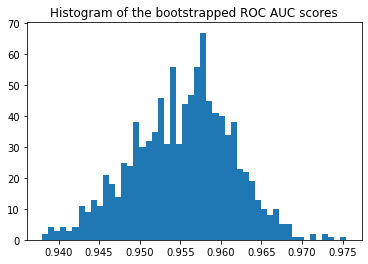

Confidence interval for the score: [0.94 - 0.96]
Original ROC area: 0.69
Bootstrap #1 ROC area: 0.71
Bootstrap #2 ROC area: 0.73
Bootstrap #3 ROC area: 0.69
Bootstrap #4 ROC area: 0.71
Bootstrap #5 ROC area: 0.67
Bootstrap #6 ROC area: 0.72
Bootstrap #7 ROC area: 0.67
Bootstrap #8 ROC area: 0.72
Bootstrap #9 ROC area: 0.66
Bootstrap #10 ROC area: 0.73
Bootstrap #11 ROC area: 0.73
Bootstrap #12 ROC area: 0.72
Bootstrap #13 ROC area: 0.67
Bootstrap #14 ROC area: 0.72
Bootstrap #15 ROC area: 0.65
Bootstrap #16 ROC area: 0.71
Bootstrap #17 ROC area: 0.74
Bootstrap #18 ROC area: 0.73
Bootstrap #19 ROC area: 0.70
Bootstrap #20 ROC area: 0.71
Bootstrap #21 ROC area: 0.70
Bootstrap #22 ROC area: 0.73
Bootstrap #23 ROC area: 0.68
Bootstrap #24 ROC area: 0.69
Bootstrap #25 ROC area: 0.68
Bootstrap #26 ROC area: 0.66
Bootstrap #27 ROC area: 0.67
Bootstrap #28 ROC area: 0.69
Bootstrap #29 ROC area: 0.68
Bootstrap #30 ROC area: 0.68
Bootstrap #31 ROC area: 0.65
Bootstrap #32 ROC area: 0.70
Bootstra

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar

Bootstrap #103 ROC area: 0.66
Bootstrap #104 ROC area: 0.64
Bootstrap #105 ROC area: 0.70
Bootstrap #106 ROC area: 0.70
Bootstrap #107 ROC area: 0.67
Bootstrap #108 ROC area: 0.66
Bootstrap #109 ROC area: 0.70
Bootstrap #110 ROC area: 0.69
Bootstrap #111 ROC area: 0.66
Bootstrap #112 ROC area: 0.70
Bootstrap #113 ROC area: 0.68
Bootstrap #114 ROC area: 0.69
Bootstrap #115 ROC area: 0.70
Bootstrap #116 ROC area: 0.72
Bootstrap #117 ROC area: 0.71
Bootstrap #118 ROC area: 0.74
Bootstrap #119 ROC area: 0.66
Bootstrap #120 ROC area: 0.66
Bootstrap #121 ROC area: 0.74
Bootstrap #122 ROC area: 0.67
Bootstrap #123 ROC area: 0.74
Bootstrap #124 ROC area: 0.73
Bootstrap #125 ROC area: 0.68
Bootstrap #126 ROC area: 0.74
Bootstrap #127 ROC area: 0.72
Bootstrap #128 ROC area: 0.71
Bootstrap #129 ROC area: 0.70
Bootstrap #130 ROC area: 0.67
Bootstrap #131 ROC area: 0.68
Bootstrap #132 ROC area: 0.64
Bootstrap #133 ROC area: 0.69
Bootstrap #134 ROC area: 0.74
Bootstrap #135 ROC area: 0.69
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar


Bootstrap #232 ROC area: 0.68
Bootstrap #233 ROC area: 0.70
Bootstrap #234 ROC area: 0.69
Bootstrap #235 ROC area: 0.69
Bootstrap #236 ROC area: 0.70
Bootstrap #237 ROC area: 0.71
Bootstrap #238 ROC area: 0.69
Bootstrap #239 ROC area: 0.72
Bootstrap #240 ROC area: 0.64
Bootstrap #241 ROC area: 0.67
Bootstrap #242 ROC area: 0.70
Bootstrap #243 ROC area: 0.66
Bootstrap #244 ROC area: 0.67
Bootstrap #245 ROC area: 0.74
Bootstrap #246 ROC area: 0.69
Bootstrap #247 ROC area: 0.65
Bootstrap #248 ROC area: 0.72
Bootstrap #249 ROC area: 0.69
Bootstrap #250 ROC area: 0.72
Bootstrap #251 ROC area: 0.70
Bootstrap #252 ROC area: 0.69
Bootstrap #253 ROC area: 0.66
Bootstrap #254 ROC area: 0.68
Bootstrap #255 ROC area: 0.72
Bootstrap #256 ROC area: 0.70
Bootstrap #257 ROC area: 0.72
Bootstrap #258 ROC area: 0.70
Bootstrap #259 ROC area: 0.60
Bootstrap #260 ROC area: 0.61
Bootstrap #261 ROC area: 0.65
Bootstrap #262 ROC area: 0.69
Bootstrap #263 ROC area: 0.73
Bootstrap #264 ROC area: 0.64
Bootstrap

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar

Bootstrap #348 ROC area: 0.70
Bootstrap #349 ROC area: 0.70
Bootstrap #350 ROC area: 0.70
Bootstrap #351 ROC area: 0.63
Bootstrap #352 ROC area: 0.72
Bootstrap #353 ROC area: 0.74
Bootstrap #354 ROC area: 0.70
Bootstrap #355 ROC area: 0.70
Bootstrap #356 ROC area: 0.69
Bootstrap #357 ROC area: 0.73
Bootstrap #358 ROC area: 0.66
Bootstrap #359 ROC area: 0.71
Bootstrap #360 ROC area: 0.64
Bootstrap #361 ROC area: 0.76
Bootstrap #362 ROC area: 0.66
Bootstrap #363 ROC area: 0.70
Bootstrap #364 ROC area: 0.70
Bootstrap #365 ROC area: 0.71
Bootstrap #366 ROC area: 0.67
Bootstrap #367 ROC area: 0.76
Bootstrap #368 ROC area: 0.70
Bootstrap #369 ROC area: 0.69
Bootstrap #370 ROC area: 0.70
Bootstrap #371 ROC area: 0.63
Bootstrap #372 ROC area: 0.70
Bootstrap #373 ROC area: 0.71
Bootstrap #374 ROC area: 0.68
Bootstrap #375 ROC area: 0.70
Bootstrap #376 ROC area: 0.67
Bootstrap #377 ROC area: 0.70
Bootstrap #378 ROC area: 0.67
Bootstrap #379 ROC area: 0.71
Bootstrap #380 ROC area: 0.73
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar

Bootstrap #464 ROC area: 0.68
Bootstrap #465 ROC area: 0.66
Bootstrap #466 ROC area: 0.68
Bootstrap #467 ROC area: 0.73
Bootstrap #468 ROC area: 0.71
Bootstrap #469 ROC area: 0.67
Bootstrap #470 ROC area: 0.71
Bootstrap #471 ROC area: 0.69
Bootstrap #472 ROC area: 0.70
Bootstrap #473 ROC area: 0.71
Bootstrap #474 ROC area: 0.68
Bootstrap #475 ROC area: 0.69
Bootstrap #476 ROC area: 0.65
Bootstrap #477 ROC area: 0.73
Bootstrap #478 ROC area: 0.72
Bootstrap #479 ROC area: 0.67
Bootstrap #480 ROC area: 0.64
Bootstrap #481 ROC area: 0.74
Bootstrap #482 ROC area: 0.70
Bootstrap #483 ROC area: 0.68
Bootstrap #484 ROC area: 0.67
Bootstrap #485 ROC area: 0.70
Bootstrap #486 ROC area: 0.74
Bootstrap #487 ROC area: 0.72
Bootstrap #488 ROC area: 0.60
Bootstrap #489 ROC area: 0.68
Bootstrap #490 ROC area: 0.72
Bootstrap #491 ROC area: 0.70
Bootstrap #492 ROC area: 0.70
Bootstrap #493 ROC area: 0.67
Bootstrap #494 ROC area: 0.69
Bootstrap #495 ROC area: 0.66
Bootstrap #496 ROC area: 0.71
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar

Bootstrap #605 ROC area: 0.71
Bootstrap #606 ROC area: 0.70
Bootstrap #607 ROC area: 0.73
Bootstrap #608 ROC area: 0.67
Bootstrap #609 ROC area: 0.65
Bootstrap #610 ROC area: 0.75
Bootstrap #611 ROC area: 0.67
Bootstrap #612 ROC area: 0.68
Bootstrap #613 ROC area: 0.66
Bootstrap #614 ROC area: 0.64
Bootstrap #615 ROC area: 0.71
Bootstrap #616 ROC area: 0.66
Bootstrap #617 ROC area: 0.69
Bootstrap #618 ROC area: 0.73
Bootstrap #619 ROC area: 0.76
Bootstrap #620 ROC area: 0.73
Bootstrap #621 ROC area: 0.72
Bootstrap #622 ROC area: 0.71
Bootstrap #623 ROC area: 0.69
Bootstrap #624 ROC area: 0.71
Bootstrap #625 ROC area: 0.64
Bootstrap #626 ROC area: 0.65
Bootstrap #627 ROC area: 0.69
Bootstrap #628 ROC area: 0.69
Bootstrap #629 ROC area: 0.67
Bootstrap #630 ROC area: 0.71
Bootstrap #631 ROC area: 0.68
Bootstrap #632 ROC area: 0.66
Bootstrap #633 ROC area: 0.64
Bootstrap #634 ROC area: 0.72
Bootstrap #635 ROC area: 0.68
Bootstrap #636 ROC area: 0.68
Bootstrap #637 ROC area: 0.63
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar


Bootstrap #752 ROC area: 0.72
Bootstrap #753 ROC area: 0.66
Bootstrap #754 ROC area: 0.70
Bootstrap #755 ROC area: 0.68
Bootstrap #756 ROC area: 0.70
Bootstrap #757 ROC area: 0.68
Bootstrap #758 ROC area: 0.67
Bootstrap #759 ROC area: 0.68
Bootstrap #760 ROC area: 0.74
Bootstrap #761 ROC area: 0.73
Bootstrap #762 ROC area: 0.73
Bootstrap #763 ROC area: 0.68
Bootstrap #764 ROC area: 0.66
Bootstrap #765 ROC area: 0.68
Bootstrap #766 ROC area: 0.65
Bootstrap #767 ROC area: 0.66
Bootstrap #768 ROC area: 0.65
Bootstrap #769 ROC area: 0.67
Bootstrap #770 ROC area: 0.71
Bootstrap #771 ROC area: 0.68
Bootstrap #772 ROC area: 0.66
Bootstrap #773 ROC area: 0.67
Bootstrap #774 ROC area: 0.72
Bootstrap #775 ROC area: 0.75
Bootstrap #776 ROC area: 0.70
Bootstrap #777 ROC area: 0.74
Bootstrap #778 ROC area: 0.73
Bootstrap #779 ROC area: 0.70
Bootstrap #780 ROC area: 0.67
Bootstrap #781 ROC area: 0.72
Bootstrap #782 ROC area: 0.67
Bootstrap #783 ROC area: 0.70
Bootstrap #784 ROC area: 0.70
Bootstrap

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar

Bootstrap #901 ROC area: 0.69
Bootstrap #902 ROC area: 0.69
Bootstrap #903 ROC area: 0.64
Bootstrap #904 ROC area: 0.69
Bootstrap #905 ROC area: 0.68
Bootstrap #906 ROC area: 0.71
Bootstrap #907 ROC area: 0.65
Bootstrap #908 ROC area: 0.66
Bootstrap #909 ROC area: 0.70
Bootstrap #910 ROC area: 0.70
Bootstrap #911 ROC area: 0.67
Bootstrap #912 ROC area: 0.71
Bootstrap #913 ROC area: 0.71
Bootstrap #914 ROC area: 0.72
Bootstrap #915 ROC area: 0.74
Bootstrap #916 ROC area: 0.73
Bootstrap #917 ROC area: 0.71
Bootstrap #918 ROC area: 0.69
Bootstrap #919 ROC area: 0.72
Bootstrap #920 ROC area: 0.67
Bootstrap #921 ROC area: 0.65
Bootstrap #922 ROC area: 0.69
Bootstrap #923 ROC area: 0.68
Bootstrap #924 ROC area: 0.68
Bootstrap #925 ROC area: 0.77
Bootstrap #926 ROC area: 0.65
Bootstrap #927 ROC area: 0.71
Bootstrap #928 ROC area: 0.71
Bootstrap #929 ROC area: 0.63
Bootstrap #930 ROC area: 0.65
Bootstrap #931 ROC area: 0.64
Bootstrap #932 ROC area: 0.72
Bootstrap #933 ROC area: 0.75
Bootstrap 

<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 626 + 1) instead
  indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
<ipython-input-32-1393675ce4ff>:17: DeprecationWar

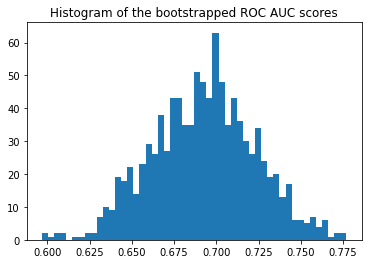

Confidence interval for the score: [0.64 - 0.74]
25特征：
0.95 (0.94-0.96) 0.9260577265383247 0.7 (0.63-0.76) 0.69 (0.64-0.74)
train train_CV test validation
[0.9662522646788713, 0.9140468822740093, 0.6801916032685263, 0.7211246555508851]
['0.95 (0.94-0.96)', 0.9260577265383247, '0.7 (0.63-0.76)', '0.69 (0.64-0.74)']


In [37]:
train_pos['outcome'] = [1 for i in range(train_pos.shape[0])]
train_neg['outcome'] = [0 for i in range(train_neg.shape[0])]
test_pos['outcome'] = [1 for i in range(test_pos.shape[0])]
test_neg['outcome'] = [0 for i in range(test_neg.shape[0])]

trainset = pd.concat([train_pos, train_neg], axis=0) # 拼接
testset = pd.concat([test_pos, test_neg], axis=0) # 拼接
X_train = trainset[feature_total]
X_test = testset[feature_total]
y_train = trainset['outcome']
y_test = testset['outcome']
                                                                                                            
validation_pos['outcome'] = [1 for i in range(validation_pos.shape[0])]
validation_neg['outcome'] = [0 for i in range(validation_neg.shape[0])]
validationset = pd.concat([validation_pos, validation_neg], axis=0) # 拼接
X_validation = validationset[feature_total]
y_validation = validationset['outcome']


# 随机数
seed = 123

####### 过采样
over_sample = SMOTE(sampling_strategy='minority', random_state=seed)
X_train, y_train = over_sample.fit_resample(X_train, y_train)
X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=seed) # 打乱

# 保存标准化+过采样的全特征数据集
X_df_train = pd.DataFrame(X_train, columns=feature_total)
X_df_test = pd.DataFrame(X_test, columns=feature_total)
X_df_validation = pd.DataFrame(X_validation, columns=feature_total)

####### 方差筛选
selector = VarianceThreshold(threshold=2.1)
selector.fit_transform(X_train, y_train)
feature_VarianceThreshold = selector.get_feature_names_out(input_features=feature_total)
feature_VarianceThreshold.tolist()

X_train = np.array(X_df_train[feature_VarianceThreshold])
X_test = np.array(X_df_test[feature_VarianceThreshold])
X_validation = np.array(X_df_validation[feature_VarianceThreshold])

# 待用数据集转为np
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

######## XGB建模
model_XGB = XGBClassifier(n_estimators=40, max_depth=1, subsample=0.9, 
                      colsample_bytree=1, reg_alpha= 0.1, 
                      objective= 'binary:logistic', nthread=8,
                    scale_pos_weight=1, seed=123)
model_XGB.fit(X_train, y_train)  

test_auc_XGB = metrics.roc_auc_score(y_test, model_XGB.predict_proba(X_test)[:,1])
train_auc_XGB = metrics.roc_auc_score(y_train, model_XGB.predict_proba(X_train)[:,1])
validation_auc_XGB = metrics.roc_auc_score(y_validation, model_XGB.predict_proba(X_validation)[:,1])
train_auc_XGB_CV = cross_val_score(model_XGB, X_train, y_train, cv=10, scoring='roc_auc')
train_auc_XGB_CV = train_auc_XGB_CV.mean()

print(len(feature_VarianceThreshold))
print('全部特征：')                                                                                                 
print(train_auc_XGB, train_auc_XGB_CV, test_auc_XGB, validation_auc_XGB)
list1 = [train_auc_XGB, train_auc_XGB_CV, test_auc_XGB, validation_auc_XGB]

####### 重要性
X_columns = feature_VarianceThreshold
importance_XGB = model_XGB.feature_importances_
imp_result = np.argsort(importance_XGB)[::-1][:]
for j in range(len(imp_result)):
    print("%2d. %-*s %f" % (j + 1, 30, X_columns[imp_result[j]], importance_XGB[imp_result[j]]))
X_columns_XGB = [X_columns[j] for j in imp_result]
col_name = []
imp_num = []
for j in range(len(imp_result)):
    col_name.append(X_columns[imp_result[j]])
    imp_num.append(importance_XGB[imp_result[j]])
col_name = np.array(col_name)
col_name = col_name[:,np.newaxis]
imp_num = np.array(imp_num)
imp_num = imp_num[:,np.newaxis]
feature_importance_XGB = np.hstack([col_name, imp_num])

feature_importance_np = feature_importance_XGB[:100,:]

'''
###### 置信区间
confidence_interval_test_XGB = Confidence_Interval(model_XGB.predict_proba(X_test)[:,1], y_test)
confidence_interval_train_XGB = Confidence_Interval(model_XGB.predict_proba(X_train)[:,1], y_train)

###### 其他指标
f1_test_XGB, f2_test_XGB, f05_test_XGB, precision_test_XGB, recall_test_XGB, PPV_test_XGB, NPV_test_XGB, FAR_test_XGB, accuracy_test_XGB, specificity_test_XGB = sk_matrix(model_XGB, y_test, model_XGB.predict(X_test))
f1_train_XGB, f2_train_XGB, f05_train_XGB, precision_train_XGB, recall_train_XGB, PPV_train_XGB, NPV_train_XGB, FAR_train_XGB, accuracy_train_XGB, specificity_train_XGB = sk_matrix(model_XGB, y_train, model_XGB.predict(X_train))
index_test = [f1_test_XGB, f2_test_XGB, f05_test_XGB, precision_test_XGB, recall_test_XGB, PPV_test_XGB, NPV_test_XGB, FAR_test_XGB, accuracy_test_XGB, specificity_test_XGB]
index_train = [f1_train_XGB, f2_train_XGB, f05_train_XGB, precision_train_XGB, recall_train_XGB, PPV_train_XGB, NPV_train_XGB, FAR_train_XGB, accuracy_train_XGB, specificity_train_XGB]

index_test_list.append(index_test); index_train_list.append(index_train)
'''
#############################第二次建模
####### 准备数据
n_feature = 25
X_train = np.array(X_df_train[feature_importance_XGB[:n_feature, 0]])
X_test = np.array(X_df_test[feature_importance_XGB[:n_feature, 0]])
X_validation = np.array(X_df_validation[feature_importance_XGB[:n_feature, 0]])

# 待用数据集转为np
X_train = np.array(X_train)
X_test = np.array(X_test)
X_validation = np.array(X_validation)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_validation = np.array(y_validation)

####### 第二次XGB建模
model_XGB = XGBClassifier(n_estimators=40, max_depth=1, subsample=0.9, 
                      colsample_bytree=1, reg_alpha= 0.1, 
                      objective= 'binary:logistic', nthread=8,
                    scale_pos_weight=1, seed=123)
model_XGB.fit(X_train, y_train)  

test_auc_XGB = metrics.roc_auc_score(y_test, model_XGB.predict_proba(X_test)[:,1])
train_auc_XGB = metrics.roc_auc_score(y_train, model_XGB.predict_proba(X_train)[:,1])
validation_auc_XGB = metrics.roc_auc_score(y_validation, model_XGB.predict_proba(X_validation)[:,1])
train_auc_XGB_CV = cross_val_score(model_XGB, X_train, y_train, cv=10, scoring='roc_auc')
train_auc_XGB_CV = train_auc_XGB_CV.mean()

###### 置信区间
confidence_interval_test_XGB = Confidence_Interval(model_XGB.predict_proba(X_test)[:,1], y_test)
confidence_interval_train_XGB = Confidence_Interval(model_XGB.predict_proba(X_train)[:,1], y_train)
confidence_interval_validation_XGB = Confidence_Interval(model_XGB.predict_proba(X_validation)[:,1], y_validation)

train_auc_XGB = str(round(train_auc_XGB, 2)) + ' ' + confidence_interval_train_XGB
test_auc_XGB = str(round(test_auc_XGB, 2)) + ' ' + confidence_interval_test_XGB
validation_auc_XGB = str(round(validation_auc_XGB, 2)) + ' ' + confidence_interval_validation_XGB

print('25特征：')                                                                                                 
print(train_auc_XGB, train_auc_XGB_CV, test_auc_XGB, validation_auc_XGB)
list2 = [train_auc_XGB, train_auc_XGB_CV, test_auc_XGB, validation_auc_XGB]

print('train', 'train_CV', 'test', 'validation')
print(list1)
print(list2)

In [19]:
feature_importance_np = np.array(feature_importance_np)
feature_importance_np = pd.DataFrame(feature_importance_np, columns=['I+II', ' '])
feature_importance_np.to_csv('feature_1+2.csv')